# ECG analysis


## Setting up the notebook
First we import the modules and set the parameters for the graphs.

In [1]:
# Imports python libraries
import numpy as np
import random as rd
import wave
import sys
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
from scipy.signal import butter, lfilter, filtfilt #for filtering data
from statistics import stdev
sys.path.insert(1, r'./../functions') # add to pythonpath

# commands to create high-resolution figures with large labels
%config InlineBackend.figure_formats = {'png', 'retina'} 
plt.rcParams['axes.labelsize'] = 16 # fontsize for figure labels
plt.rcParams['axes.titlesize'] = 18 # fontsize for figure titles
plt.rcParams['font.size'] = 14 # fontsize for figure numbers
plt.rcParams['lines.linewidth'] = 1.4 # line width for plotting

## Previous funtions
Lets redefine the functions we already know from the previous notebooks.

In [2]:
#Function that extracts the number of recording channels, sampling rate, time and signal
#variable is the path and filename of the .wav file
def ecg(variable):
    record = wave.open(variable, 'r') # load the data

    # Get the number of channels, sample rate, etc.
    numChannels = record.getnchannels() #number of channels
    numFrames = record.getnframes() #number of frames
    sampleRate = record.getframerate() #sampling rate
    sampleWidth = record.getsampwidth()
    
    # Get wave data
    dstr = record.readframes(numFrames * numChannels)
    waveData = np.frombuffer(dstr, np.int16)

    # Get time window
    timeECG = np.linspace(0, len(waveData)/sampleRate, num=len(waveData))

    return timeECG, waveData

In [3]:
def detecta_maximos_locales(timeECG, waveData, threshold_ratio=0.7):
    # If not all the R peaks are detected, lower the threshold_ratio
    # If components that are not R peaks (like T waves) are detected, higher the threshold_ratio

    if len(timeECG) != len(waveData): #Raises an error if the two arrays have different lengths
        raise Exception("The two arrays have different lengths.")
    
    interval = max(waveData) - min(waveData)
    threshold = threshold_ratio*interval + min(waveData)
    maxima = []
    maxima_indices = []
    mxs_indices = []
    banner = False
    
    for i in range(0, len(waveData)):
            
        if waveData[i] >= threshold:#If a threshold value is surpassed,
            # the indices and values are saved 
            banner = True
            maxima_indices.append(i)
            maxima.append(waveData[i])
            
        elif banner == True and waveData[i] < threshold: #If the threshold value is crossed
            # the index of the maximum value in the original array is saved
            index_local_max = maxima.index(max(maxima))
            mxs_indices.append(maxima_indices[index_local_max])
            maxima = []
            maxima_indices = []
            banner = False     

    return mxs_indices

## View ECG
Now we will view the whole recordings.

In [4]:
#Test data
nice = ["C1", "C2", "C3"]

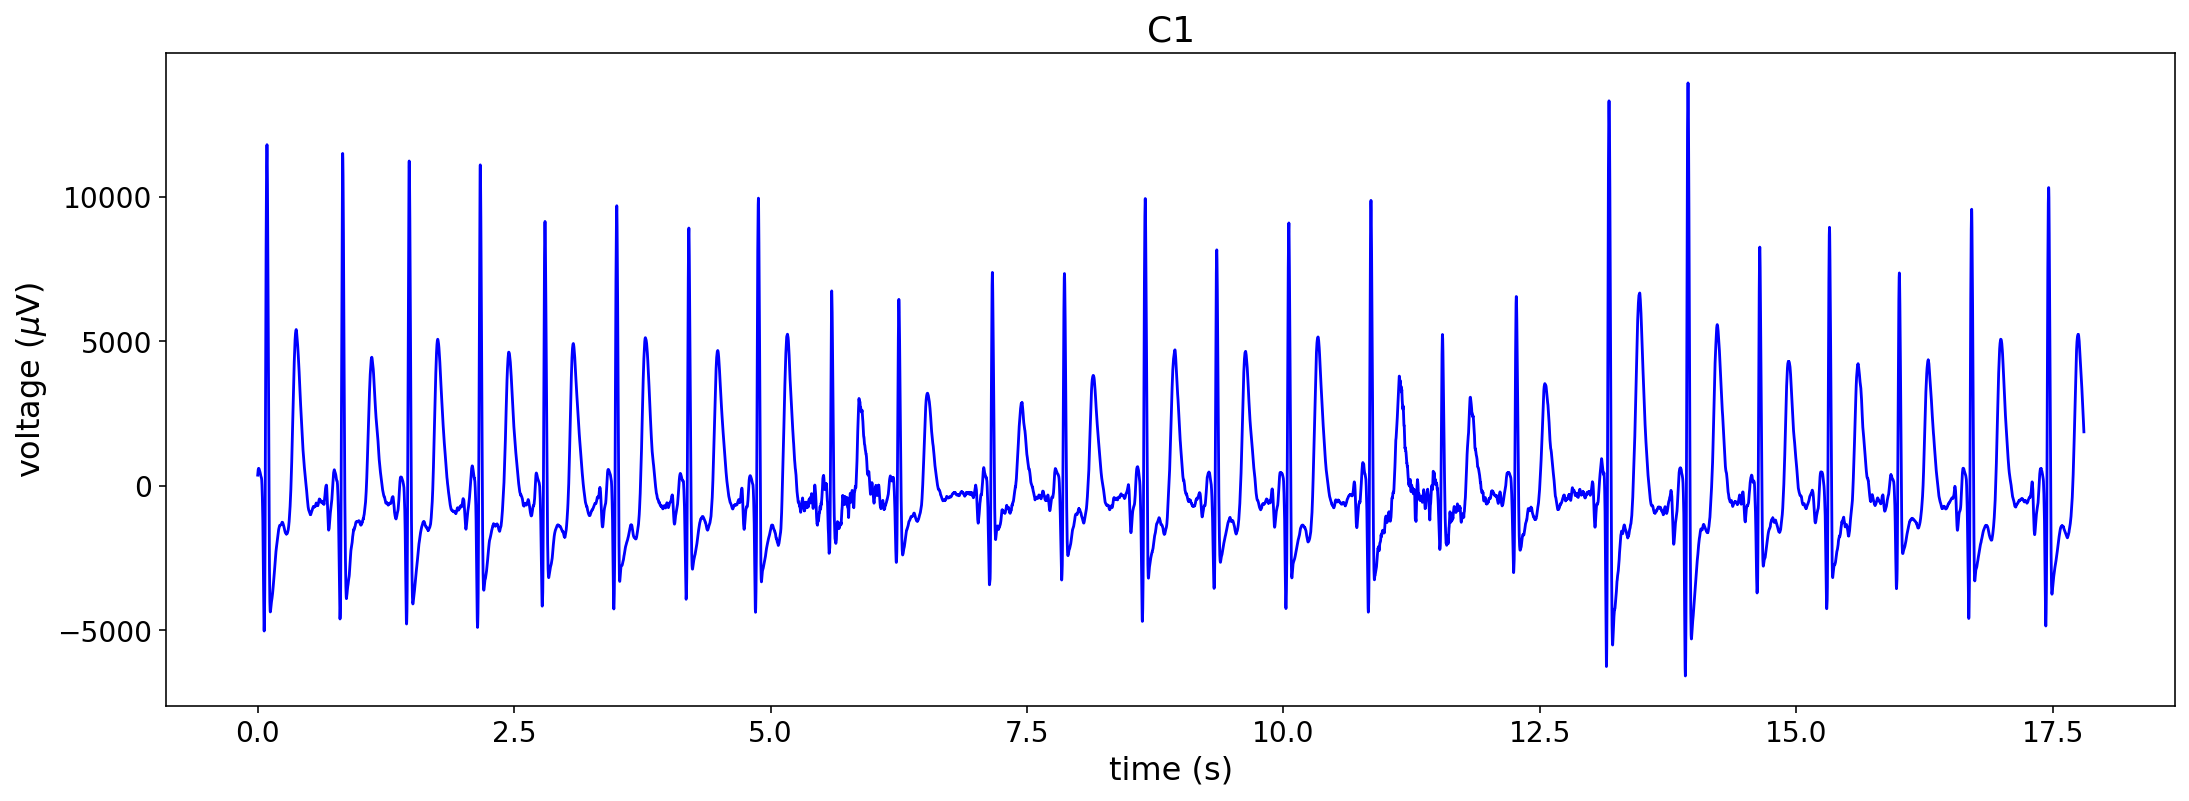

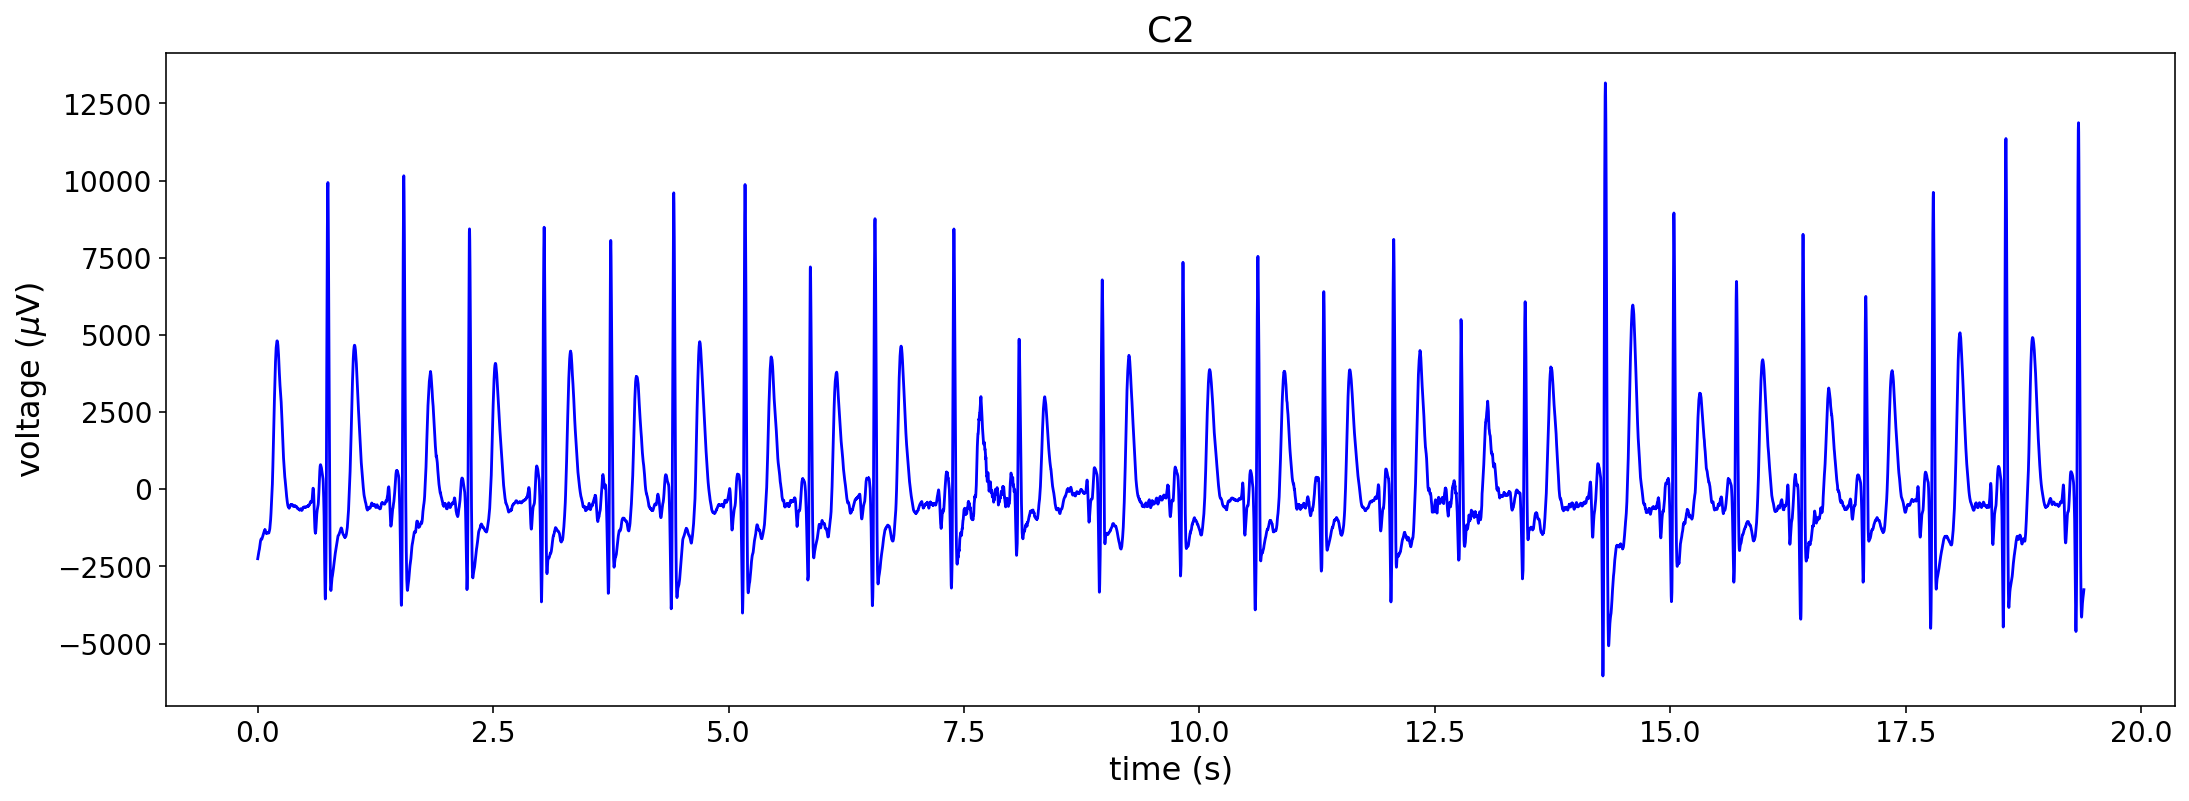

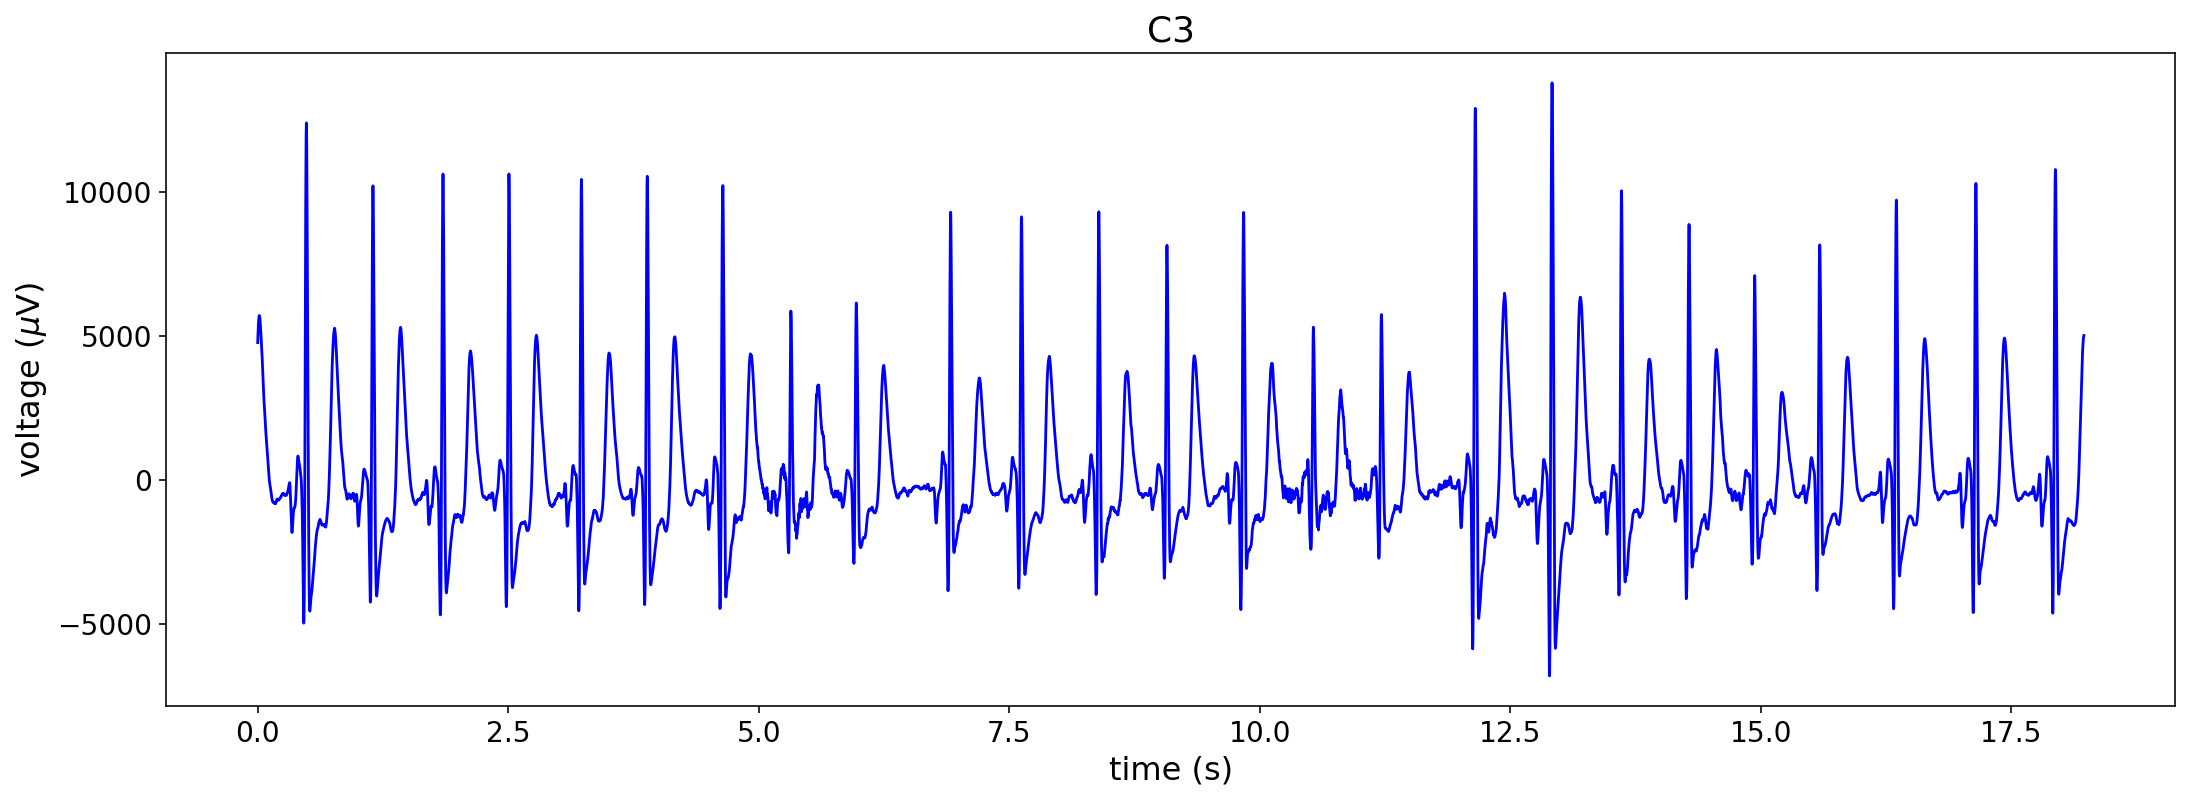

In [5]:
for i in range(0, len(nice)):
    timeECG, waveData = ecg("ECG_samples/"+nice[i]+'.wav')
    # Plotting EMG signal
    plt.figure(figsize=(18,6))
    plt.xlabel(r'time (s)')
    plt.ylabel(r'voltage ($\mu$V)')
    plt.plot(timeECG,waveData, 'b')
    plt.title(nice[i])
    plt.show()

Notice that some R preaks are higher than others. In some cases the R peaks are smaller in amplitude than T peaks of another pulse. To solve this we will need to find another way to identify R peaks. 

In [6]:
#The first sample is imported
timeECG, waveData = ecg("ECG_samples/"+nice[0]+'.wav')

(0.6, 1.5)

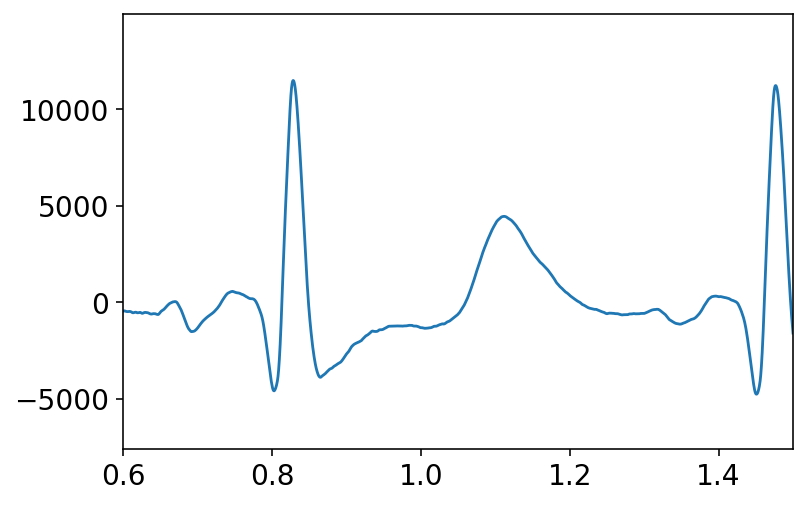

In [7]:
#The fist sample is graphed with a zoom to identify the important peaks in the ECG recording
plt.plot(timeECG,waveData)
plt.xlim(0.6,1.5)

### Excercise
On the previous graph, which peaks can you identify? Which ones can't be distinguished? Why?

## Fast Fourier Transform
To amplify the R peaks we will have to filter the signal by frequencies. We will need to find the frequencies that are less relevant to the R peaks and delete them.

In [8]:
#The fast fourier transform is calculated
X=np.fft.fft(waveData)

In [9]:
#The frequency array is calculated
N = len(X)
n = np.arange(N)
T = N*(timeECG[1]-timeECG[0])
freq = n/T 

Text(0, 0.5, 'Amplitude')

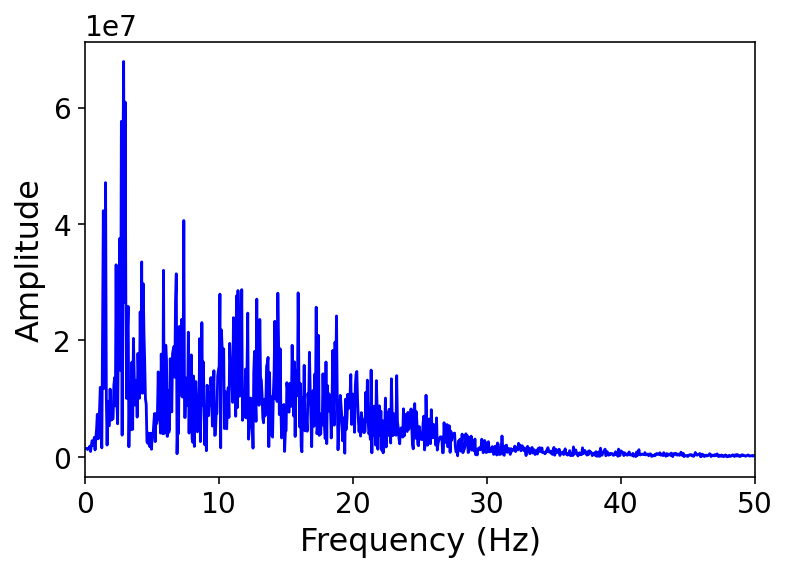

In [10]:
#Plot of the frequency function
plt.plot(freq,abs(X), 'b')
plt.xlim(0,50)
plt.xlabel("Frequency (Hz)")
plt.ylabel("Amplitude")

### Filtering the Fourier transform

Based on the previous code now we define a function that automaticaly filters an ECG using the FFT.

In [11]:
def R_fourier(fm,fM,threshold_ratio=0.7):
    r=[]
    
    for c in nice:
        #The original data is imported
        timeECG, waveData = ecg("ECG_samples/"+c+'.wav')
        print(type(waveData), type(timeECG))
        X=np.fft.fft(waveData)
        N = len(X)
        n = np.arange(N)
        T = N*(timeECG[1]-timeECG[0])
        freq = n/T 
        
        #To plot the frequency function uncomment the following lines of code:
        #plt.figure(figsize=(18,6))
        #plt.xlabel(r'Frequency (Hz)')
        #plt.ylabel(r'Fourier transform ')
        #plt.plot(freq,X, 'b')
        #plt.title(c)
        #plt.xlim(0,20)
        #plt.show()
        
        #The filters are applied 
        xc=X.copy()
        xc[freq<fm]=0
        xc[freq>fM]=0
        x2=np.fft.ifft(xc)
        
        #Now we use the same procedure as before but with the filtered function
        mxs_indices = detecta_maximos_locales(timeECG, x2,threshold_ratio)
        r.append(mxs_indices)

        # Plotting ECG signal
        plt.figure(figsize=(18,6))
        plt.xlabel(r'time (s)')
        plt.ylabel(r'voltage ($\mu$V)')
        plt.plot(timeECG,waveData, 'b')
        plt.plot(timeECG,2*x2.real,'g')
        plt.scatter(timeECG[mxs_indices], waveData[mxs_indices], color='r')
        plt.xlim(4,8)
        plt.title(c)
        plt.show()
    return(r)

### Exercise
Play with our function. Change the filtering limits and threshold until every R peak is correctly identified

<class 'numpy.ndarray'> <class 'numpy.ndarray'>


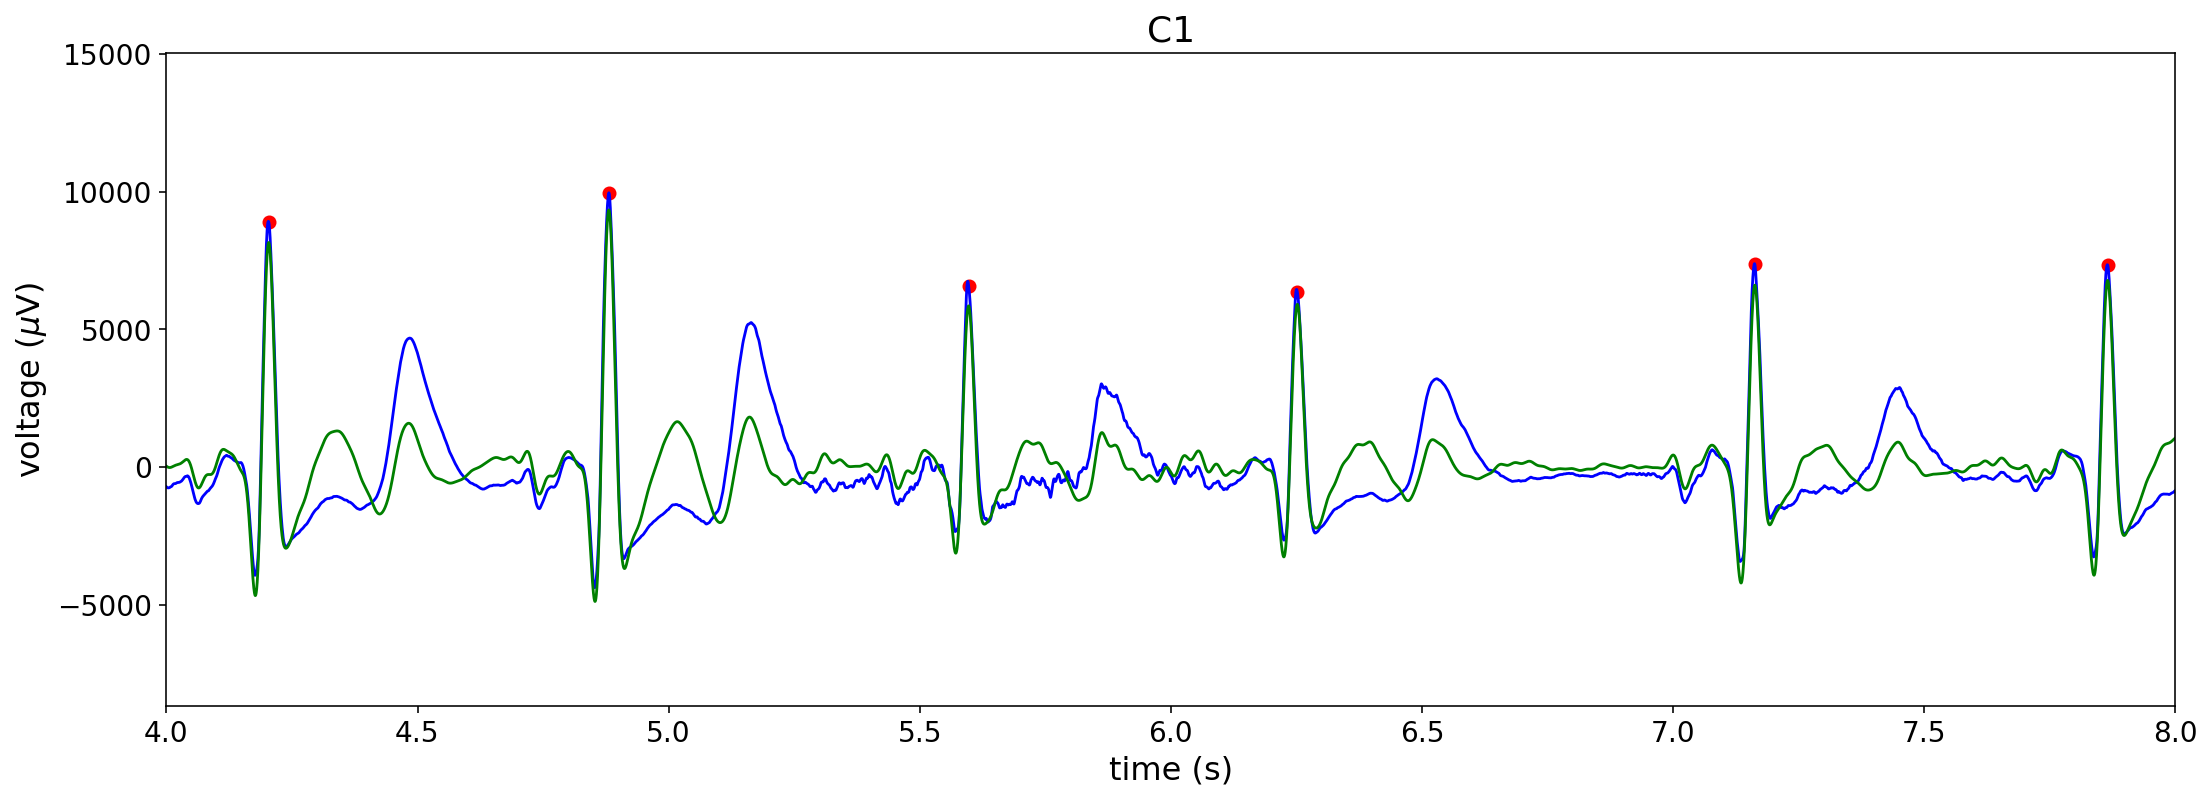

<class 'numpy.ndarray'> <class 'numpy.ndarray'>


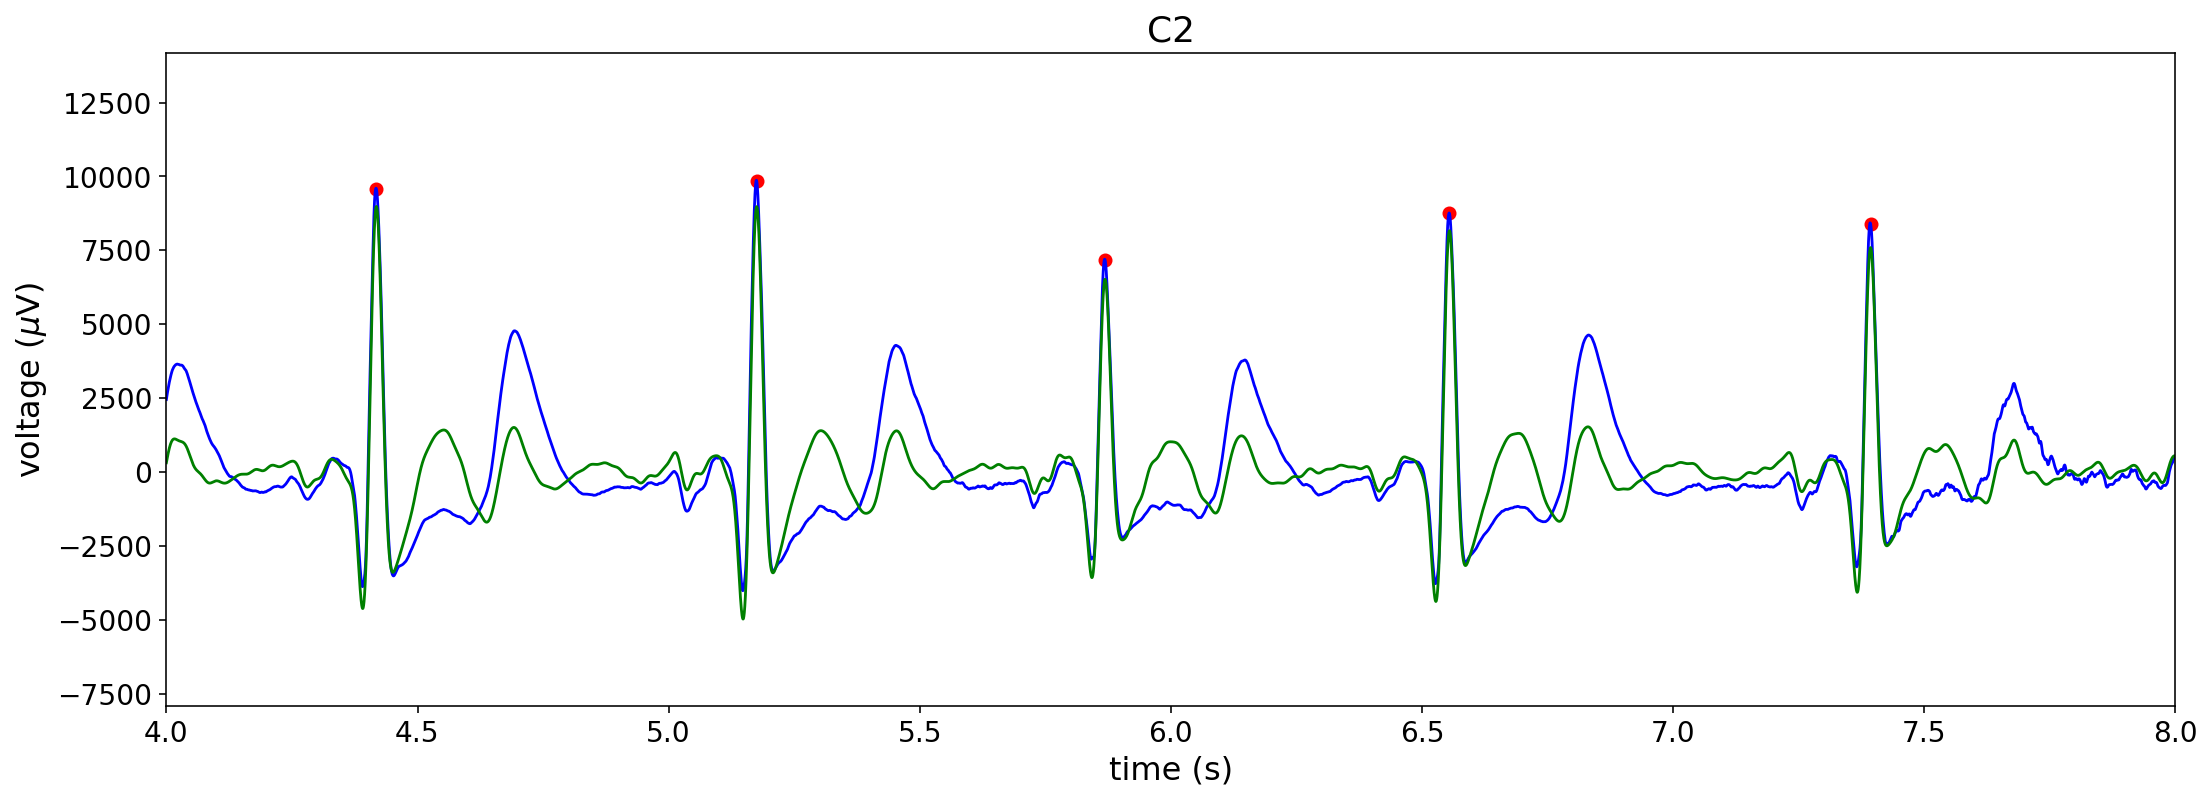

<class 'numpy.ndarray'> <class 'numpy.ndarray'>


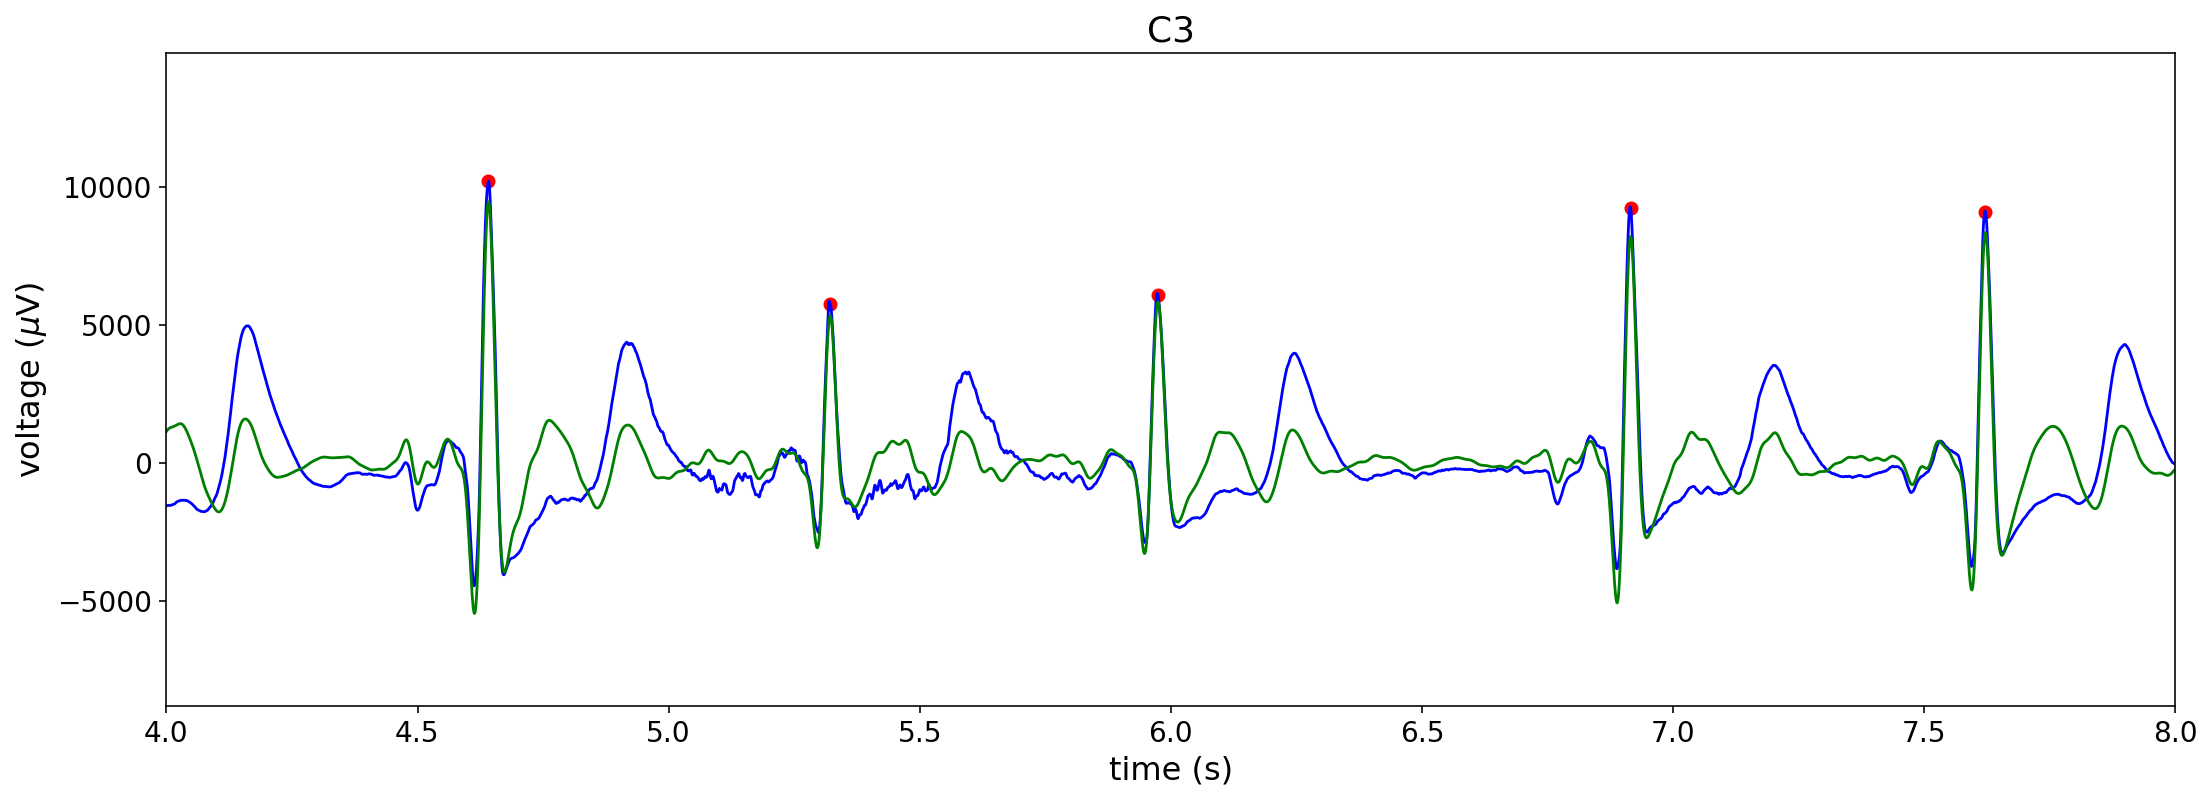

In [12]:
r=R_fourier(5,35,threshold_ratio=0.5)

## Obtaining the Q and S Peaks
We know that the Q and S peaks correspond to the last and next minimum in the ECG, so we first define functions that find the next and last minimum within a time window. 

In [13]:
#Function that finds the last minimum in a time window starting from X0
def last_min(f,x0):
    x0=x0-50
    while f[x0]!=np.min(f[x0-100:x0+100]):
        x0+=-1
    return x0
#Function that finds the next minimum in a time window starting from X0
def next_min(f,x0):
    x0=x0+50
    while f[x0]!=np.min(f[x0-100:x0+100]):
        x0+=1
    return x0
#Function that finds the next point that has the same value as the one in XO. I.e f(X0)=f(X)
def next_same(f,x0):
    a=x0+50
    while f[a]>f[x0]:
        a+=1
    return a 

In [14]:
#Now we applie this functions to an R peaks
q=last_min(waveData,r[0][1])
s=next_min(waveData,r[0][1])

(0.0, 1.0)

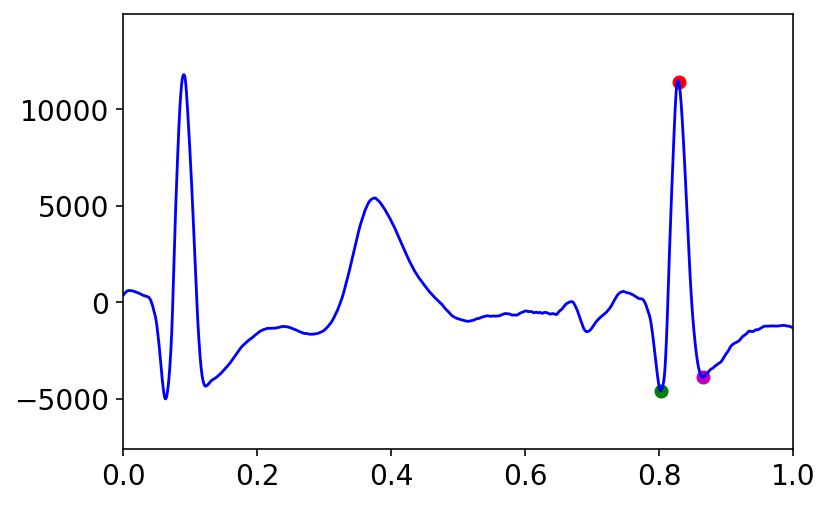

In [15]:
plt.plot(timeECG,waveData,'b')
plt.scatter(timeECG[r[0][1]],waveData[r[0][1]],color='r')
#plt.scatter(timeECG[r[0][1]-3000],waveData[r[0][1]-3000],color='r')
plt.scatter(timeECG[q],waveData[q],color='g')
plt.scatter(timeECG[s],waveData[s],color='m')
plt.xlim(0,1)

Observe that the functions work with this specific point. Now we will use them with thw hole recording

## Finding the QRS complex
Using the same procedure we find all the peaks in the QRS complex

In [16]:
def QRS_fourier(fm,fM,threshold_ratio=0.7):
    qrs=[[],[],[]]
    for c in nice:
        timeECG, waveData = ecg("ECG_samples/"+c+'.wav')
        
        X=np.fft.fft(waveData)
        N = len(X)
        n = np.arange(N)
        T = N*(timeECG[1]-timeECG[0])
        freq = n/T 
    
        
        #Frequency filters are applied to the Fourier Transform
        xc=X.copy()
        xc[freq<fm]=0
        xc[freq>fM]=0
        x2=np.fft.ifft(xc)
        
        #Obtain R peaks from the Fourier transform of ECG
        mxs_indices = detecta_maximos_locales(timeECG, x2,threshold_ratio)
        
        #Finding the index of Q and S peaks
        Q=[]
        R=[]
        S=[]
        for r in mxs_indices:
            Q.append(last_min(waveData,r))
            S.append(next_min(waveData,r))
            qrs_complex=waveData[last_min(waveData,r):next_min(waveData,r)]
            R.append(np.argmax(qrs_complex)+last_min(waveData,r))
        qrs[0].append(Q)
        qrs[2].append(S)
        qrs[1].append(R)
        
        # Plotting EMG signal
        plt.figure(figsize=(18,6))
        plt.xlabel(r'time (s)')
        plt.ylabel(r'voltage ($\mu$V)')
        plt.plot(timeECG,waveData, 'b')
        plt.scatter(timeECG[R], waveData[R], color='r')
        plt.scatter(timeECG[Q], waveData[Q], color='g')
        plt.scatter(timeECG[S], waveData[S], color='m')
        #plt.xlim(4,8)
        plt.title(c)
        plt.show()
    return(r)

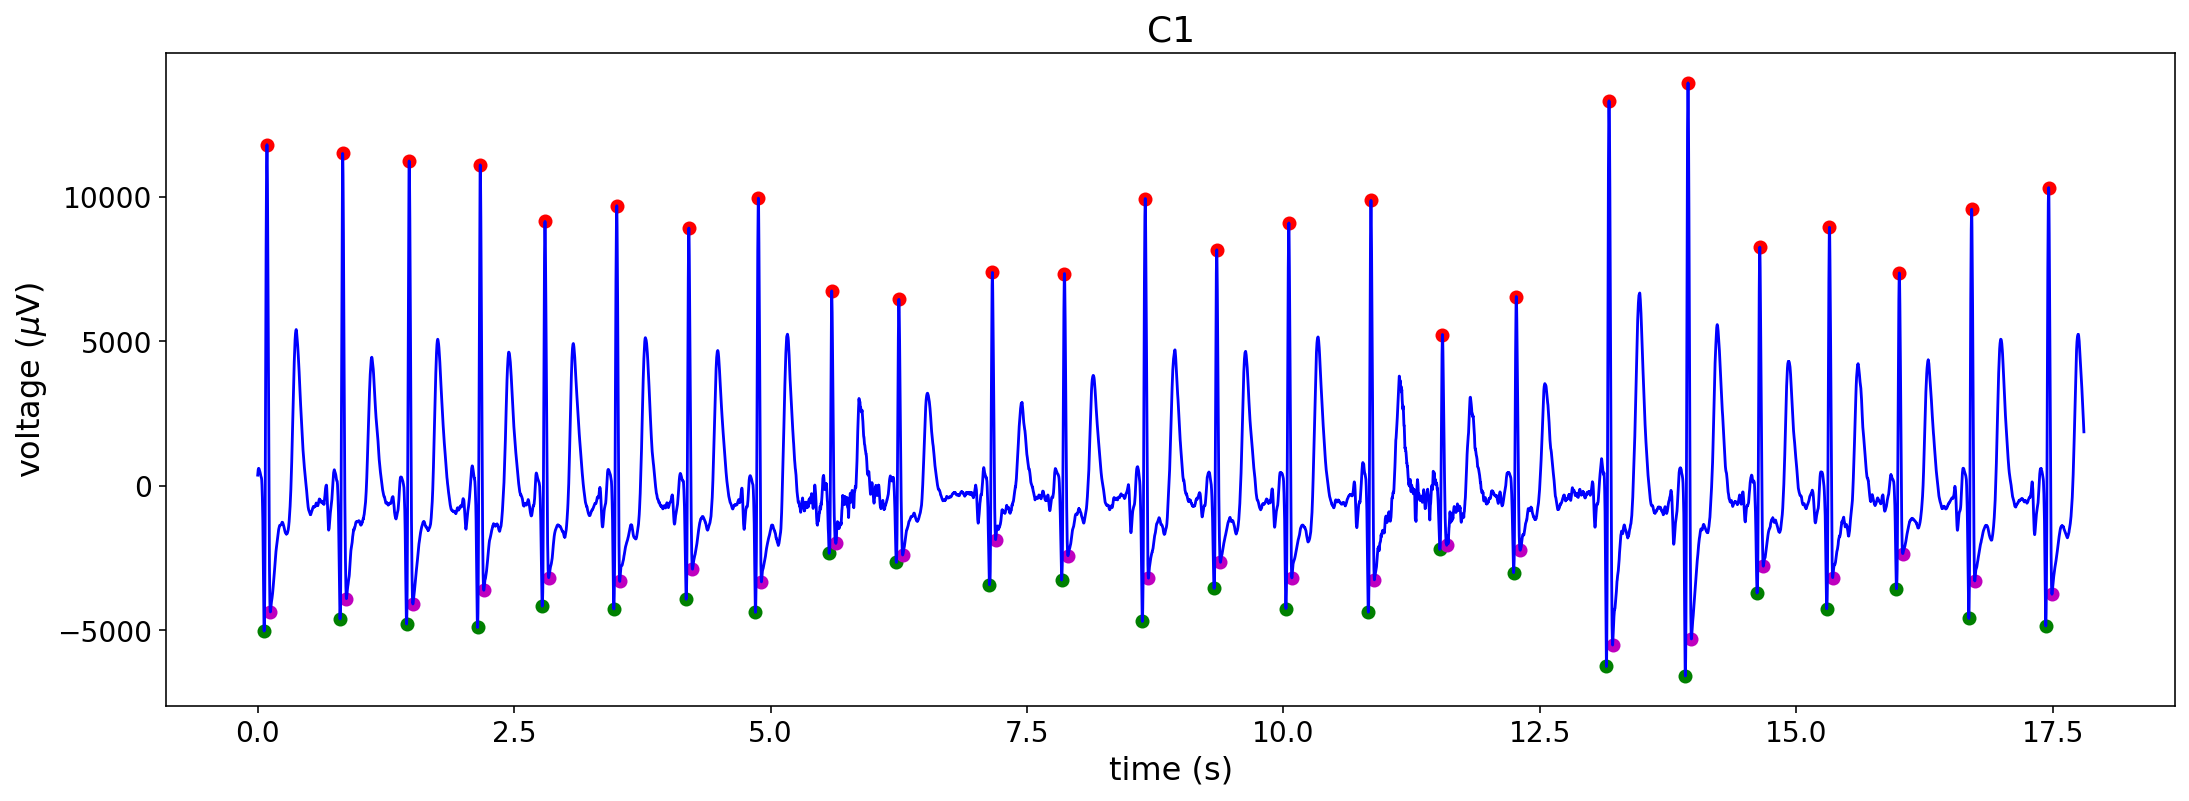

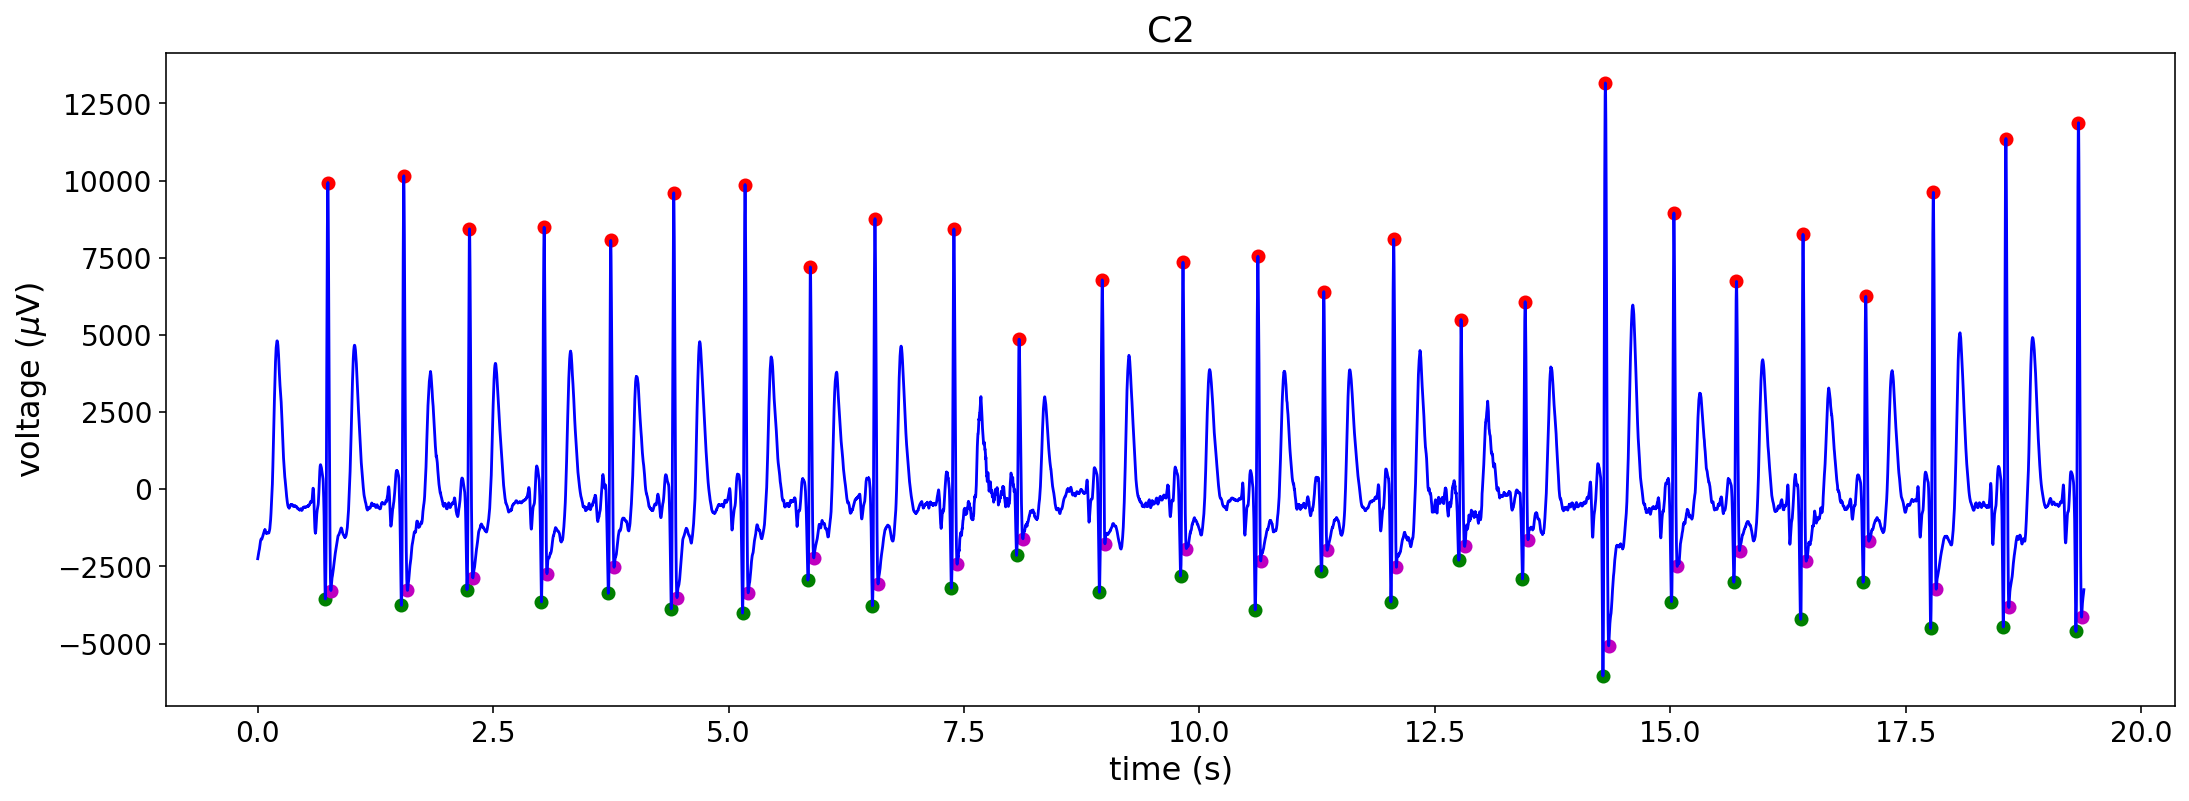

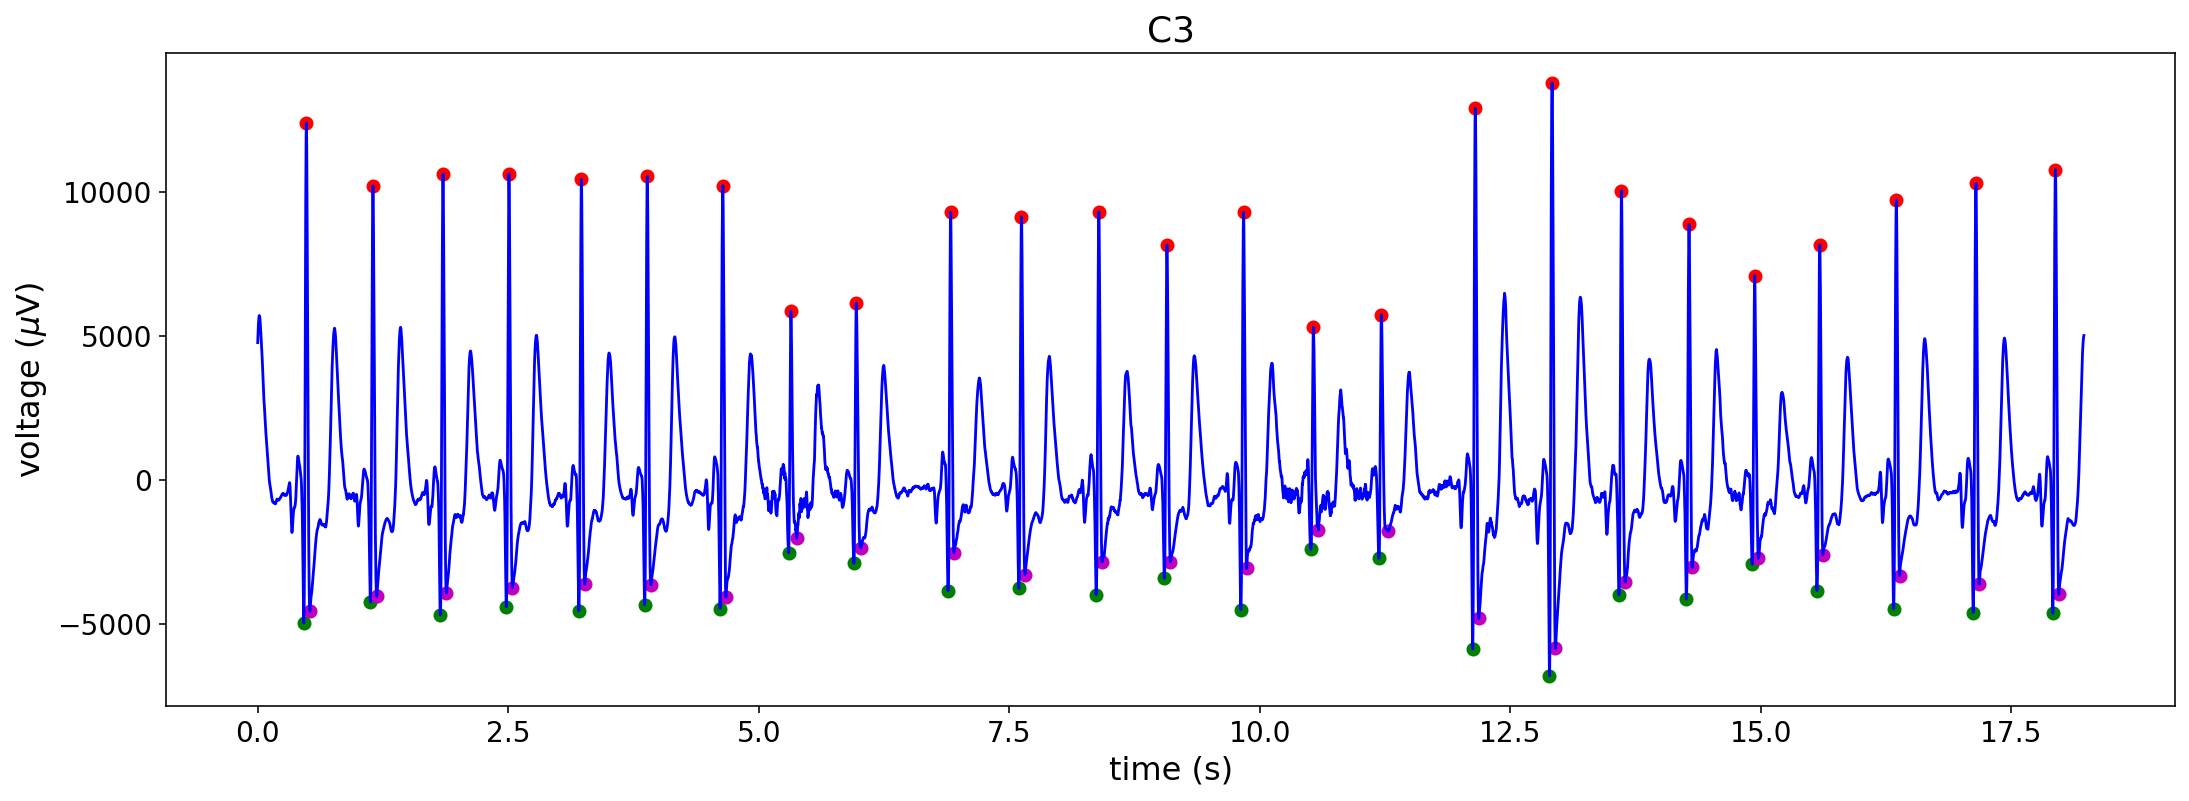

In [17]:
#qrs is an array with dimentions 3,3,N. 
#The first index indicates the peak (Q=0, R=1, S=2).
#The second index indicates the subject (C1=0, C2=1, C3=2).
#The third and last index indicates the number of peak in the signal.
#Don't forget that qrs only saves the index itself, NOT the value of the peak or the time at which it occurs.
qrs=QRS_fourier(5,35,threshold_ratio=0.5)

## Adding the P wave
We know that the p wave starts one minimum before the QRS complex and ends when the function reaches the same value it did when it started. This means that if a P wave starts in $X_i$ it must end in the next value $X_f$ that satifies $f(X_i)=f(X_f)$. We also know that the P wave can be found in a time window of 0.2 s before the Q peak. 

In [18]:
def PQRS_fourier(fm,fM,threshold_ratio=0.7):
    pqrs=[[[],[]],[],[],[]]
    for c in nice:
        timeECG, waveData = ecg("ECG_samples/"+c+'.wav')
        
        X=np.fft.fft(waveData)
        N = len(X)
        n = np.arange(N)
        T = N*(timeECG[1]-timeECG[0])
        freq = n/T 
        
        #Frequency filters are applied to the Fourier Transform
        xc=X.copy()
        xc[freq<fm]=0
        xc[freq>fM]=0
        x2=np.fft.ifft(xc)
        
        #Obtain R peaks from the Fourier transform of ECG
        mxs_indices = detecta_maximos_locales(timeECG, x2,threshold_ratio)
        
        #Finding the index of Q and S peaks
        Q=[]
        R=[]
        S=[]
        for r in mxs_indices:
            Q.append(last_min(waveData,r))
            S.append(next_min(waveData,r))
            qrs_complex=waveData[last_min(waveData,r):next_min(waveData,r)]
            R.append(np.argmax(qrs_complex)+last_min(waveData,r))
        pqrs[1].append(Q)
        pqrs[2].append(R)
        pqrs[3].append(S)
        
        #P peak is obtained with a time window of 0.2 s
        P=[[],[]]
        for i in range(0,len(R)):
            r=R[i]
            if r>2000:
                a=r-2000
                p=np.argmax(waveData[a:r-500])
                pi=np.argmin(waveData[p+a-1000:p+a])
                pf=next_same(waveData,pi+p+a-1000)
                P[0].append(pi+p+a-1000)
                P[1].append(pf)
        pqrs[0].append(P)
            
        # Plotting EMG signal
        plt.figure(figsize=(18,6))
        plt.xlabel(r'time (s)')
        plt.ylabel(r'voltage ($\mu$V)')
        plt.plot(timeECG,waveData, 'b')
        plt.scatter(timeECG[R], waveData[R], color='r')
        plt.scatter(timeECG[Q], waveData[Q], color='g')
        plt.scatter(timeECG[S], waveData[S], color='m')
        plt.scatter(timeECG[P[0]], waveData[P[0]], color='k')
        plt.scatter(timeECG[P[1]], waveData[P[1]], color='k')
        #To see the function with more detail uncomment the following line and adjust the limits:
        #plt.xlim(0,5)
        plt.title(c)
        plt.show()
    return(r)

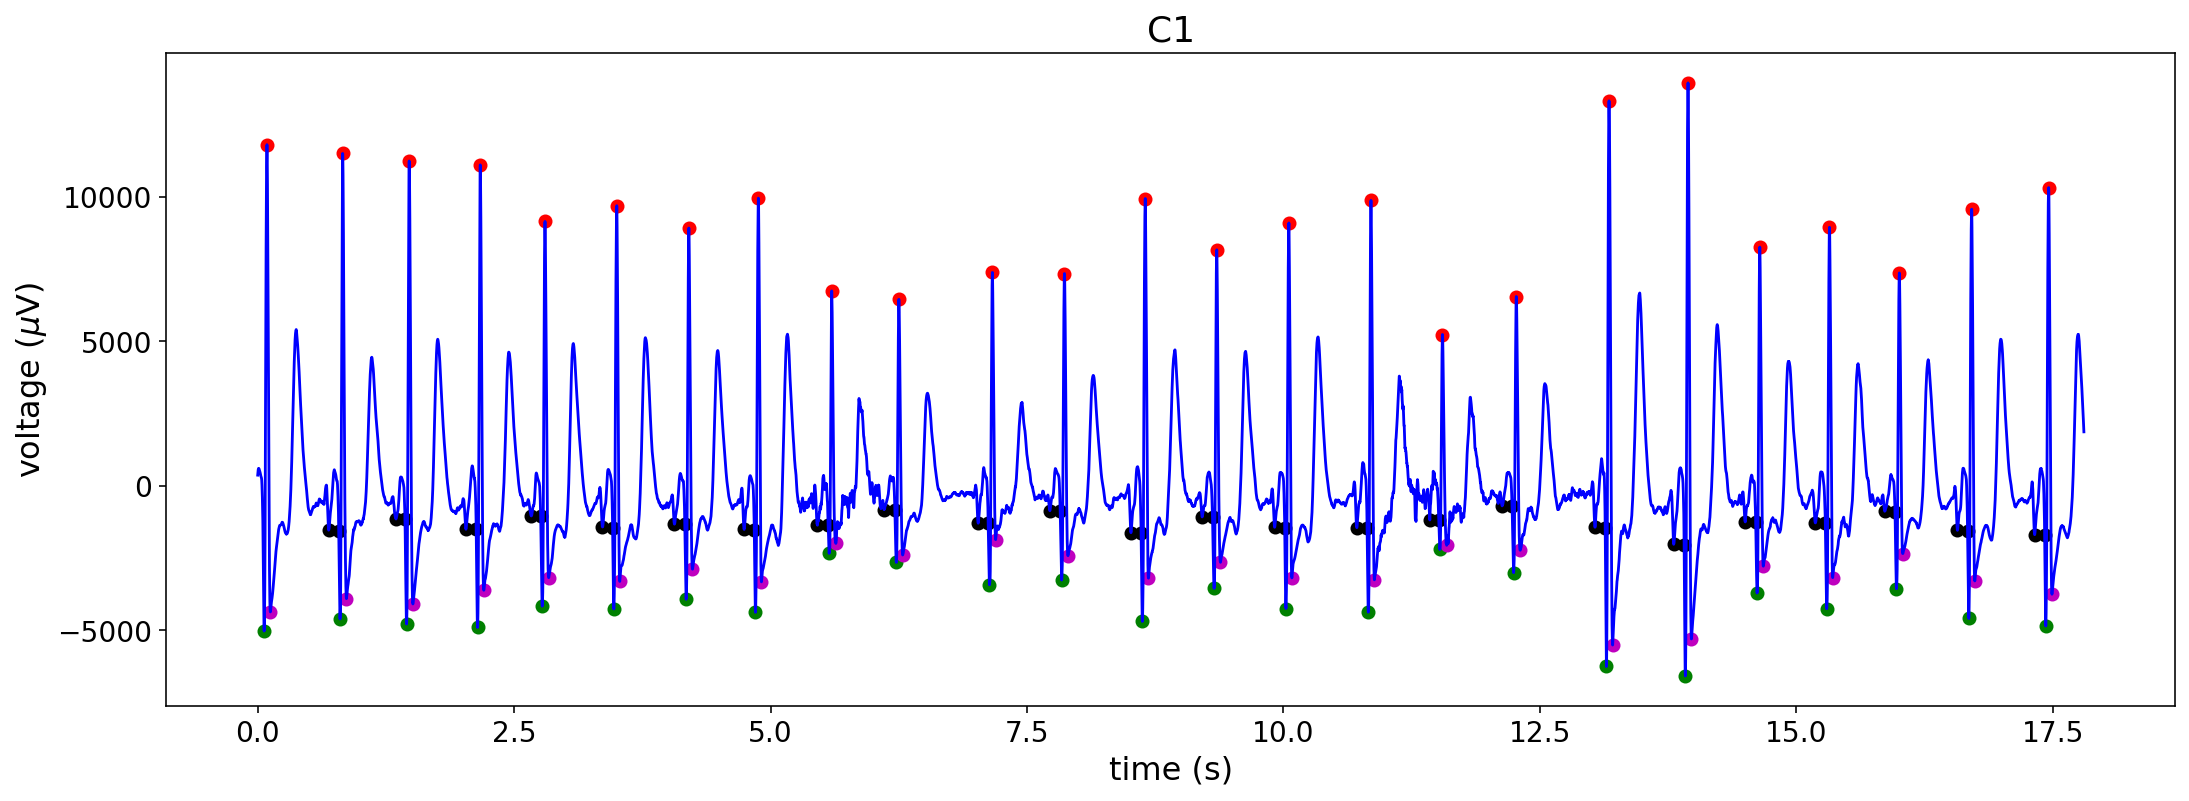

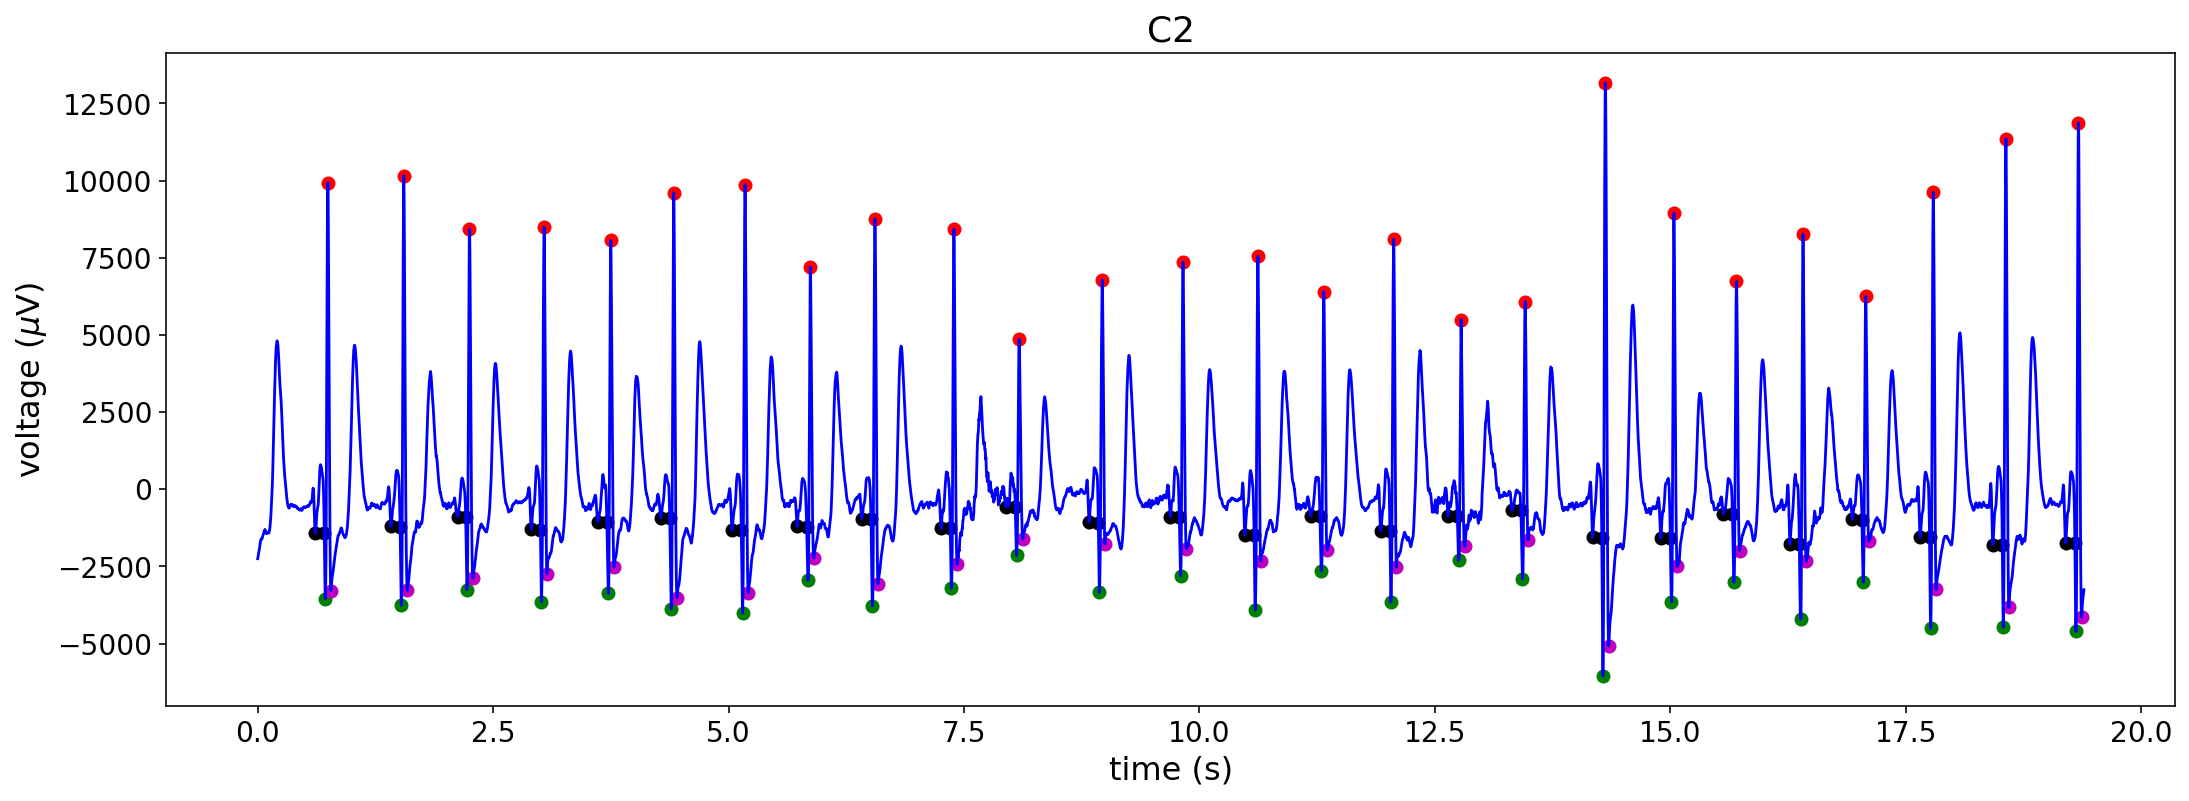

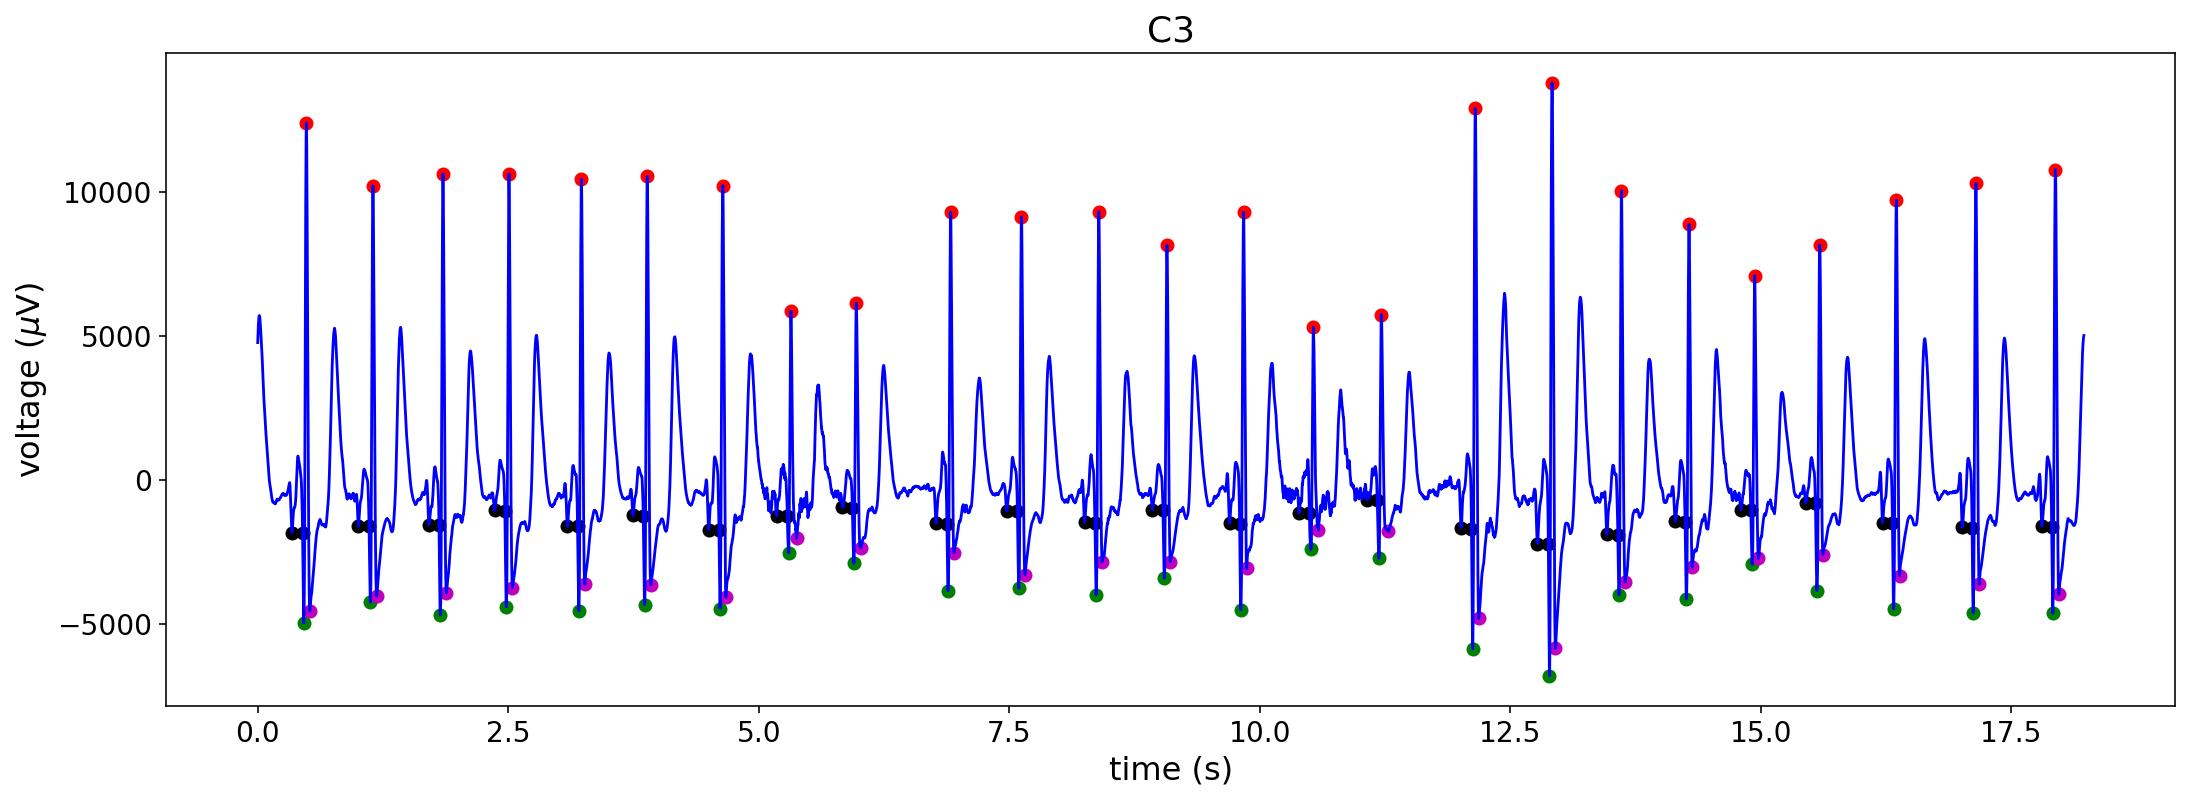

In [19]:
pqrs=PQRS_fourier(5,35,threshold_ratio=0.5)

## Adding the T wave
We know that the T wave appears in a time window of 0.44s after the QRS complex. So we must first find the maximum value reached in that time window and then we find the last and next minimums. They will correspond to the beginning and ending of the T wave respectively.

In [20]:
def PQRST_fourier(fm,fM,threshold_ratio=0.5):
    pqrst=[[],[],[],[],[]]
    for c in nice:
        timeECG, waveData = ecg("ECG_samples/"+c+'.wav')
        
        X=np.fft.fft(waveData)
        N = len(X)
        n = np.arange(N)
        T = N*(timeECG[1]-timeECG[0])
        freq = n/T 
        
        #Frequency filters are applied to the Fourier Transform
        xc=X.copy()
        xc[freq<fm]=0
        xc[freq>fM]=0
        x2=np.fft.ifft(xc)
        
        #Obtain R peaks from the Fourier transform of ECG
        mxs_indices = detecta_maximos_locales(timeECG, x2,threshold_ratio)
        
        #Finding the index of Q and S peaks
        Q=[]
        R=[]
        S=[]
        for r in mxs_indices:
            Q.append(last_min(waveData,r))
            S.append(next_min(waveData,r))
            qrs_complex=waveData[last_min(waveData,r):next_min(waveData,r)]
            R.append(np.argmax(qrs_complex)+last_min(waveData,r))
        pqrst[1].append(Q)
        pqrst[2].append(R)
        pqrst[3].append(S)
        
        #P peak is obtained with a time window of 0.2 s
        P=[[],[]]
        for i in range(0,len(R)):
            r=R[i]
            if r>2000:
                a=r-2000
                p=np.argmax(waveData[a:r-500])
                pi=np.argmin(waveData[p+a-1000:p+a])
                pf=next_same(waveData,pi+p+a-1000)
                P[0].append(pi+p+a-1000)
                P[1].append(pf)
        pqrst[0].append(P)
            
        #Finding the T peak in a window of 0.44 s after S.
        T=[[],[]]
        for i in range(0,len(S)):
            if timeECG[S[i]]<timeECG[-4400]:
                t=np.argmax(waveData[S[i]:S[i]+4400])
                ti=last_min(waveData,t+S[i]-500)
                tf=next_min(waveData,t+S[i]+500)
                T[0].append(ti)
                T[1].append(tf)
            
        # Plotting EMG signal
        plt.figure(figsize=(18,6))
        plt.xlabel(r'time (s)')
        plt.ylabel(r'voltage ($\mu$V)')
        plt.plot(timeECG,waveData, 'b')
        plt.scatter(timeECG[R], waveData[R], color='r')
        plt.scatter(timeECG[Q], waveData[Q], color='g')
        plt.scatter(timeECG[S], waveData[S], color='m')
        plt.scatter(timeECG[P[0]], waveData[P[0]], color='k')
        plt.scatter(timeECG[P[1]], waveData[P[1]], color='k')
        plt.scatter(timeECG[T[0]], waveData[T[0]], color='aqua')
        plt.scatter(timeECG[T[1]], waveData[T[1]], color='aqua')
        plt.xlim(10,12)
        plt.title(c)
        plt.show()
    return(pqrst)

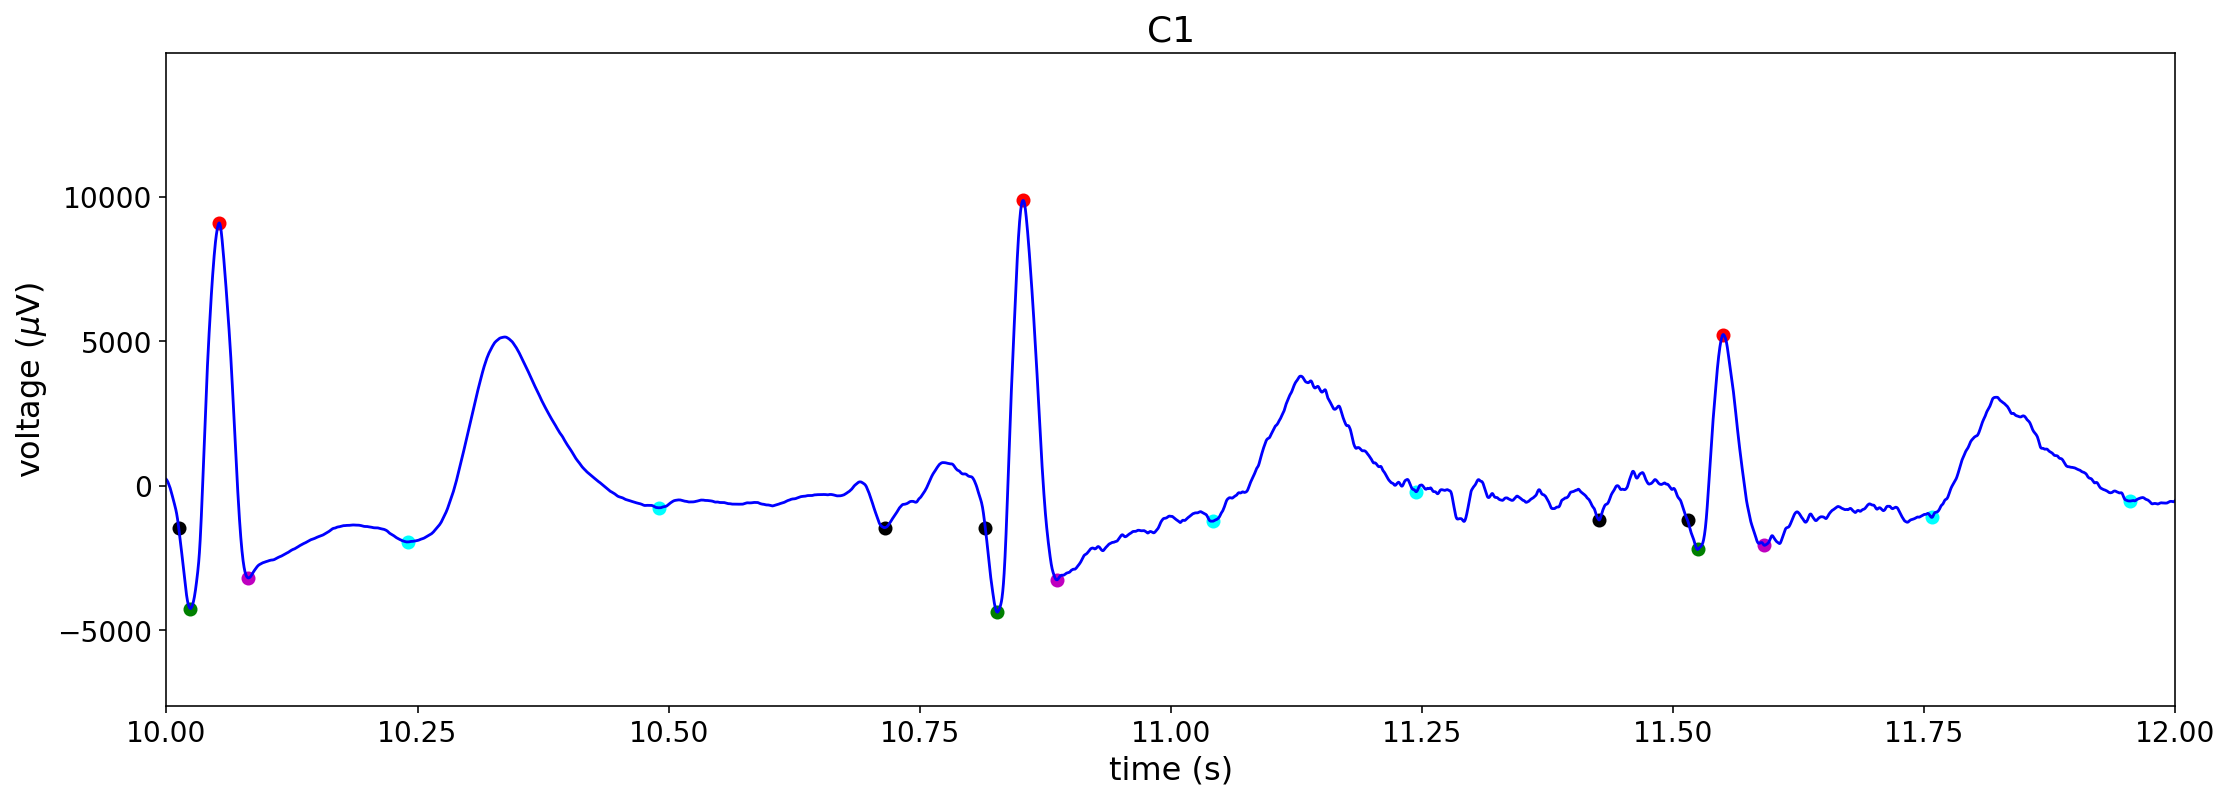

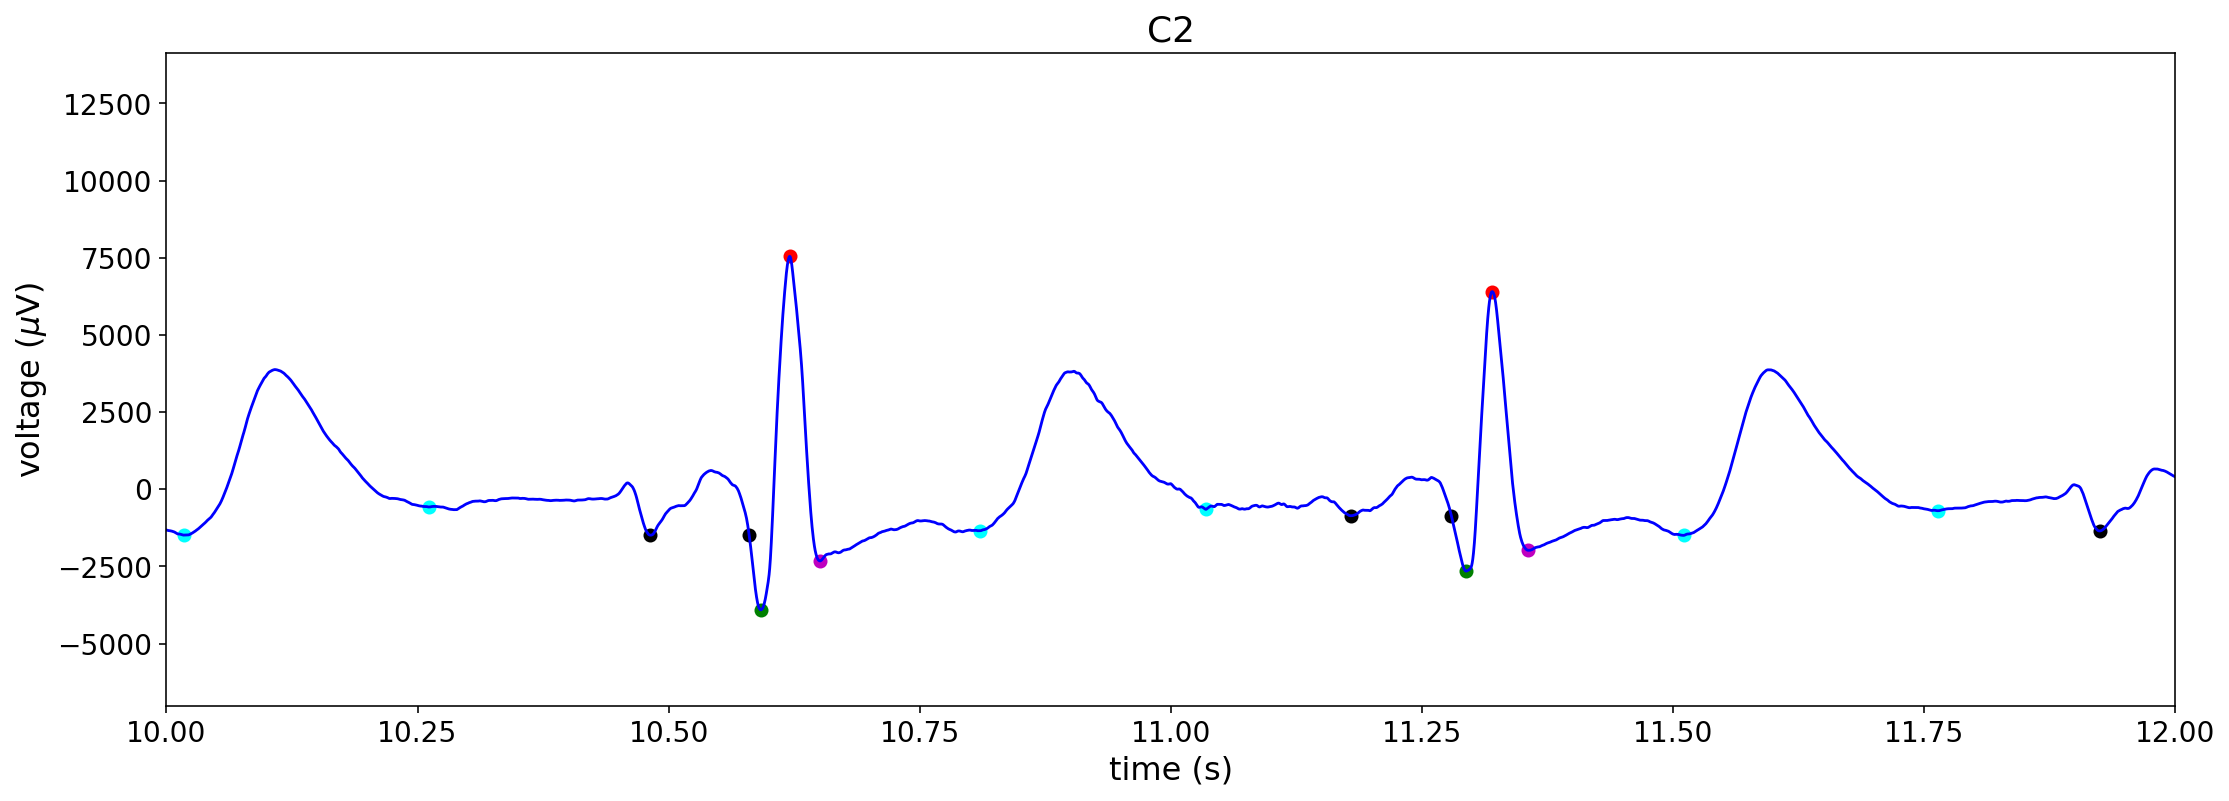

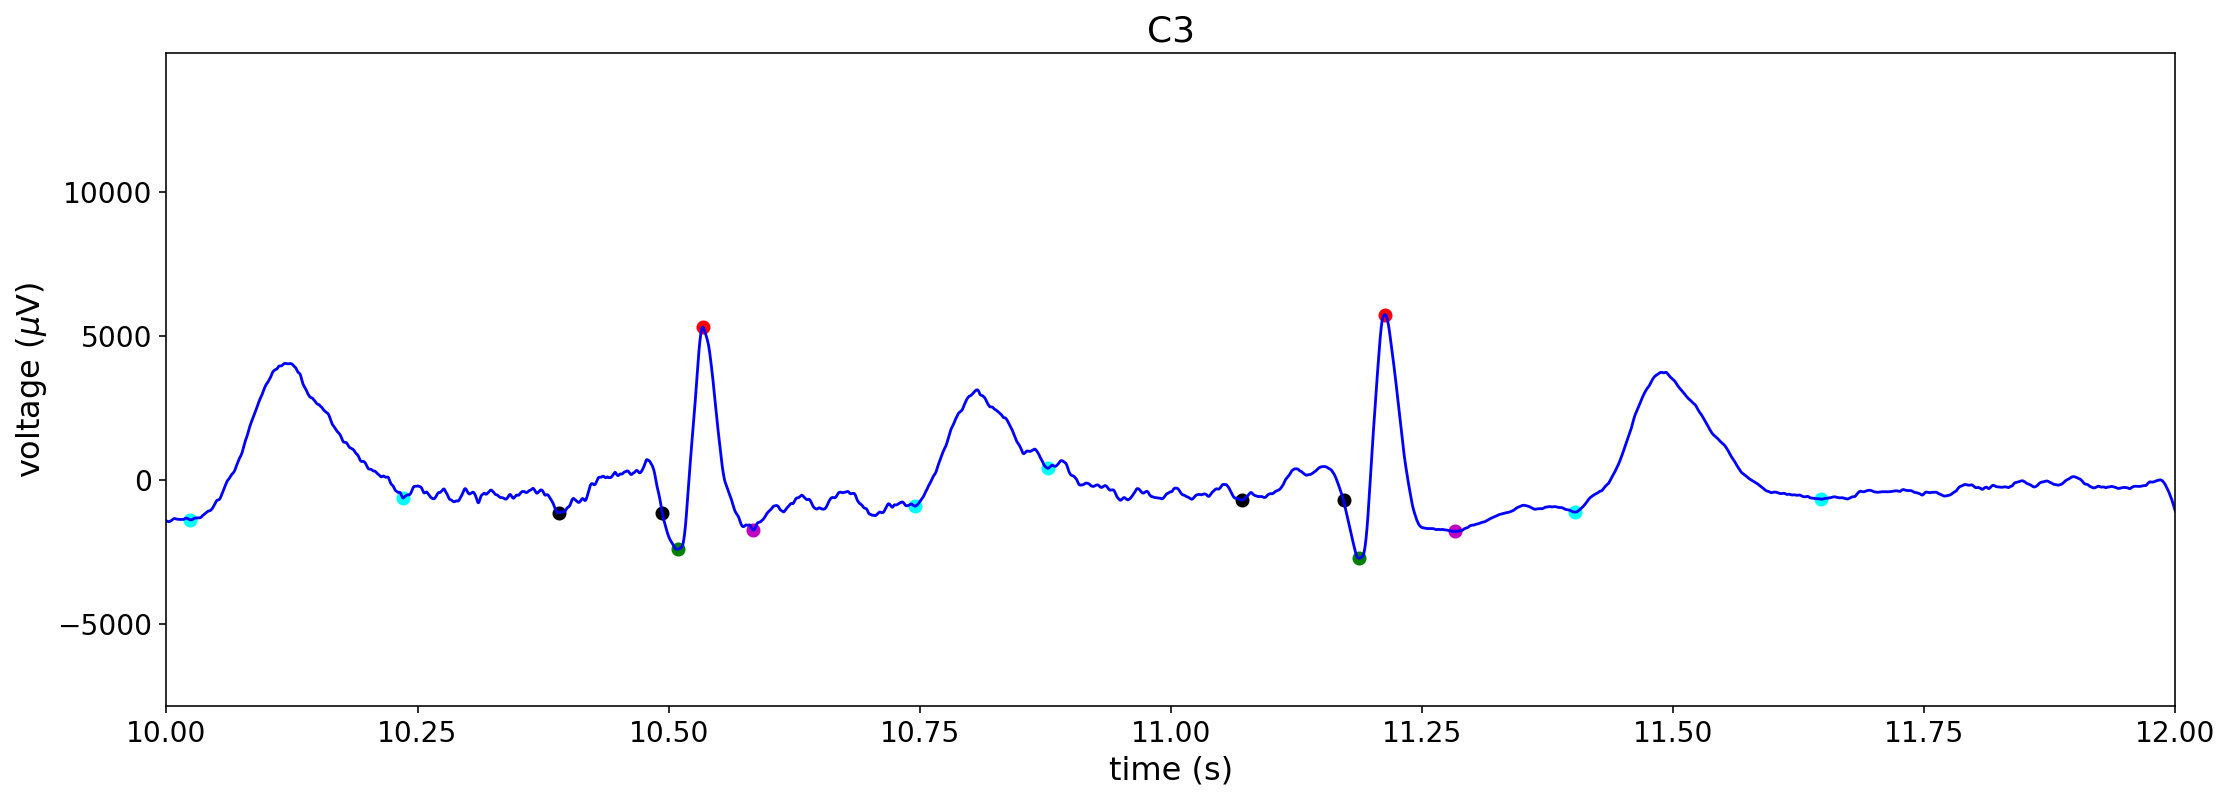

In [21]:
pqrst=PQRST_fourier(5,35)

Be free to play with the parameters used if you have any doubt.

## Analyzing the data 
Now we will graph how the heart rate changes through the recording.

### Heart rate:

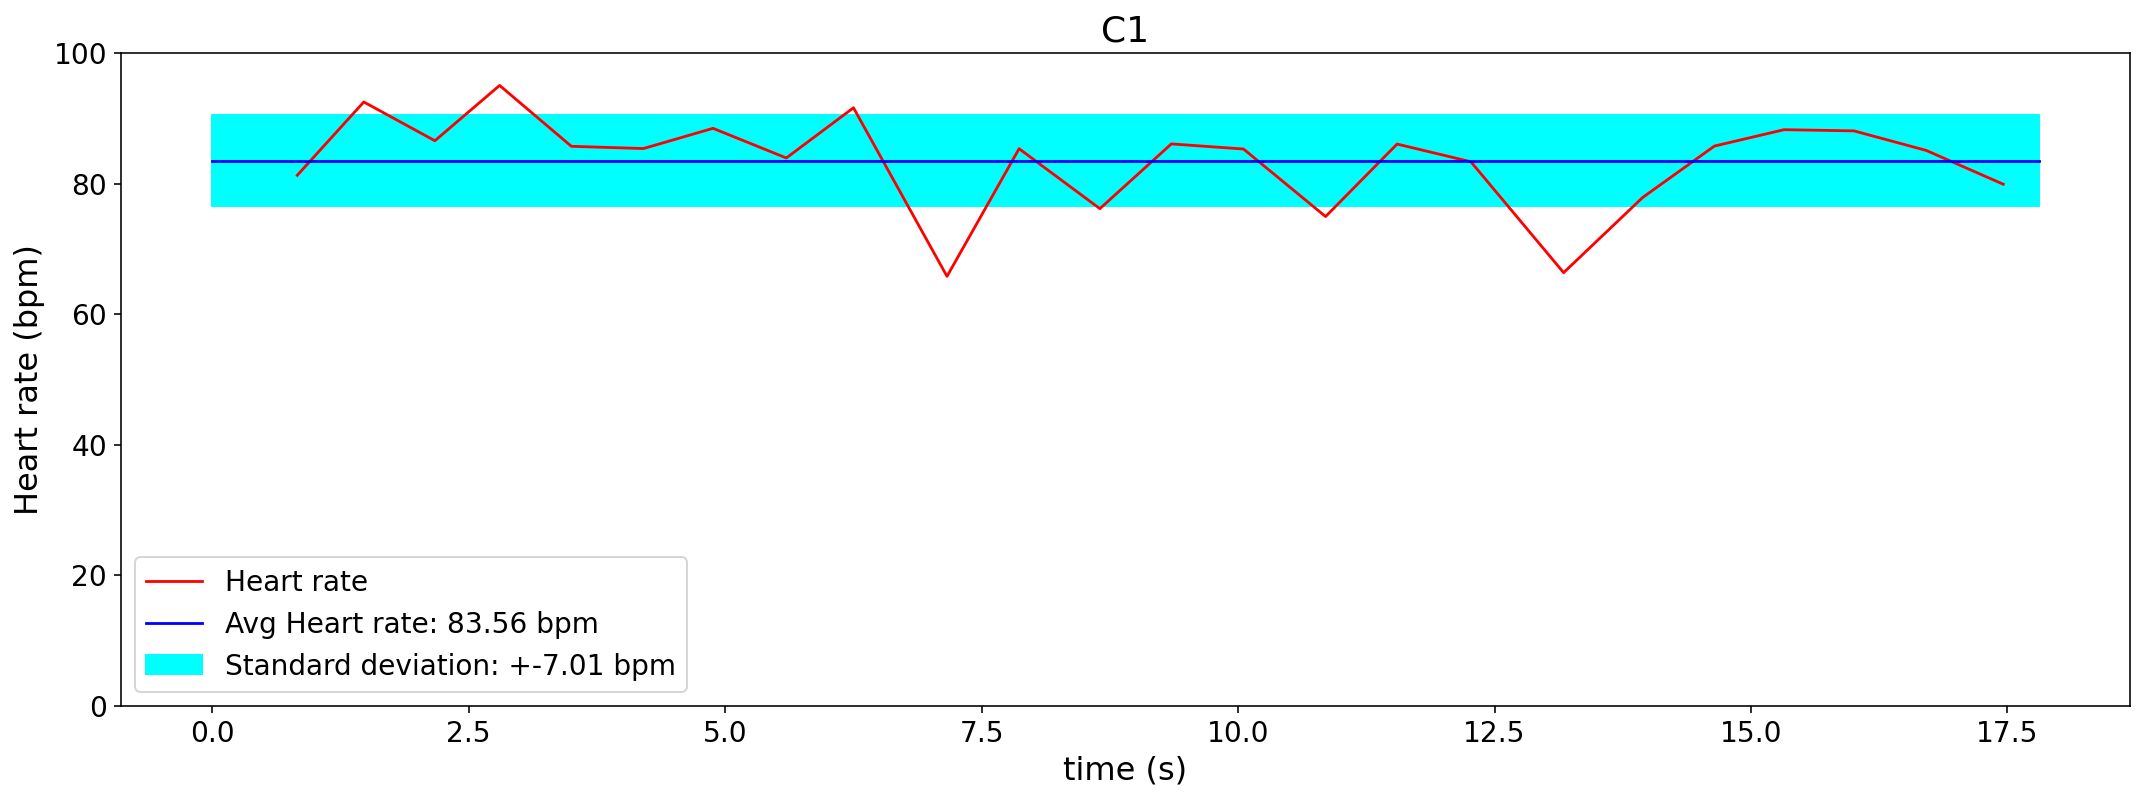

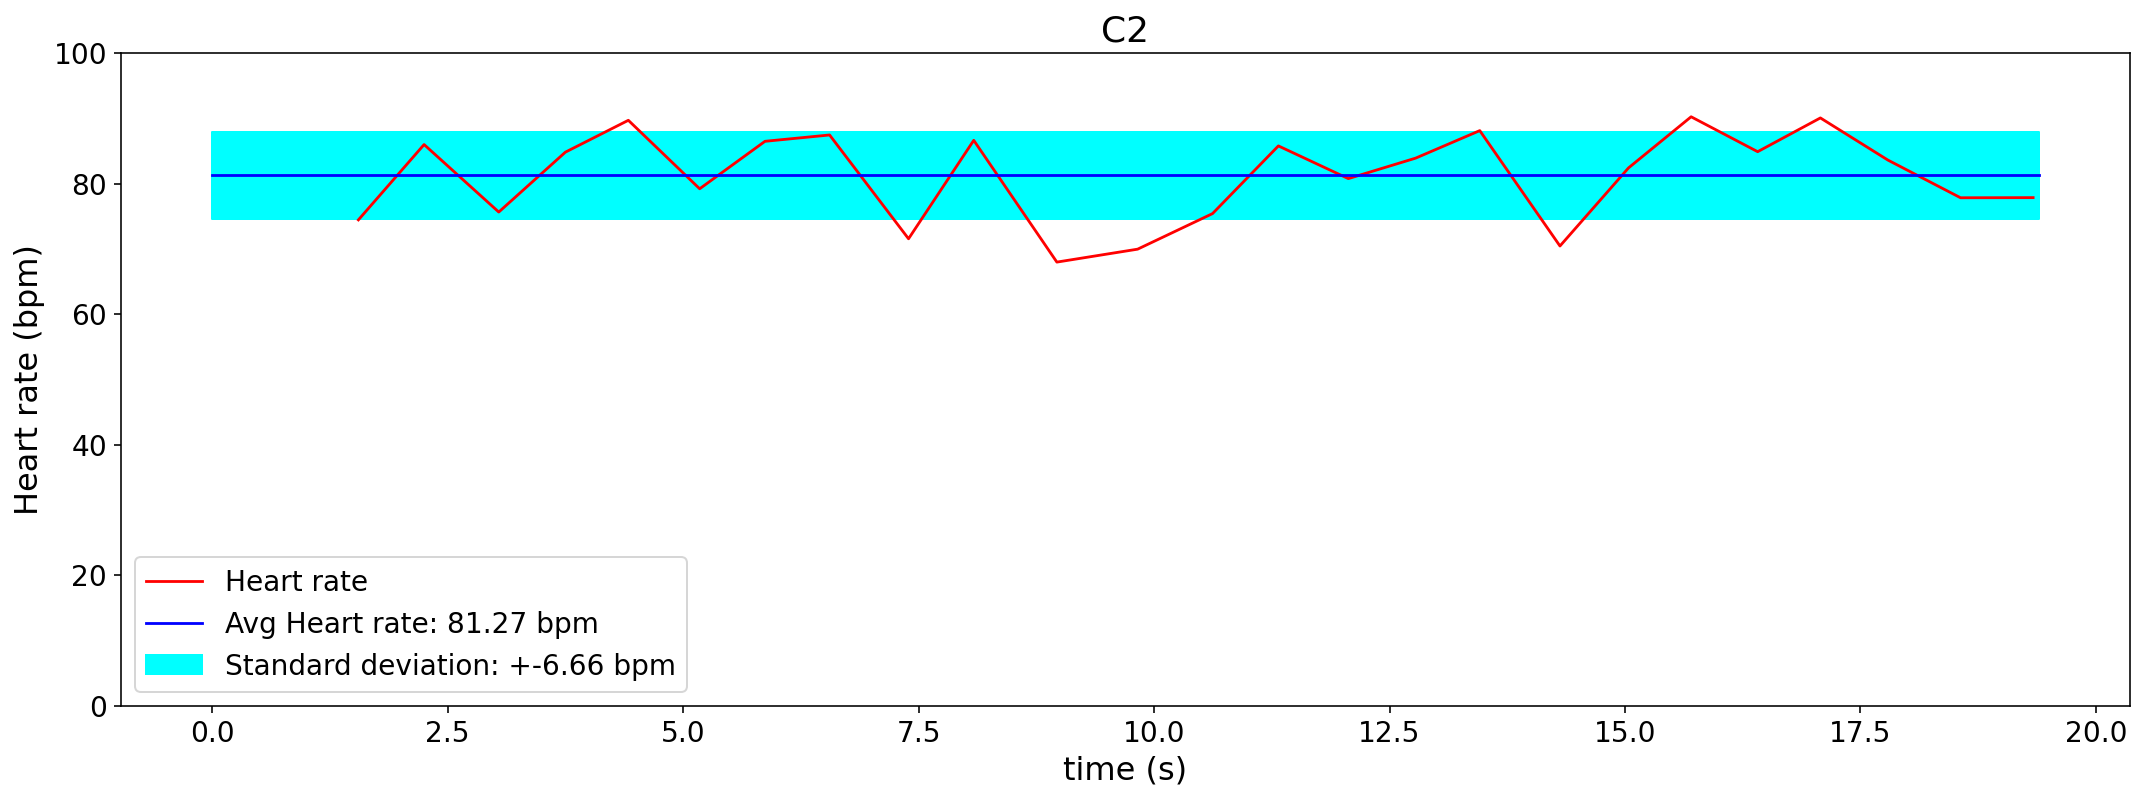

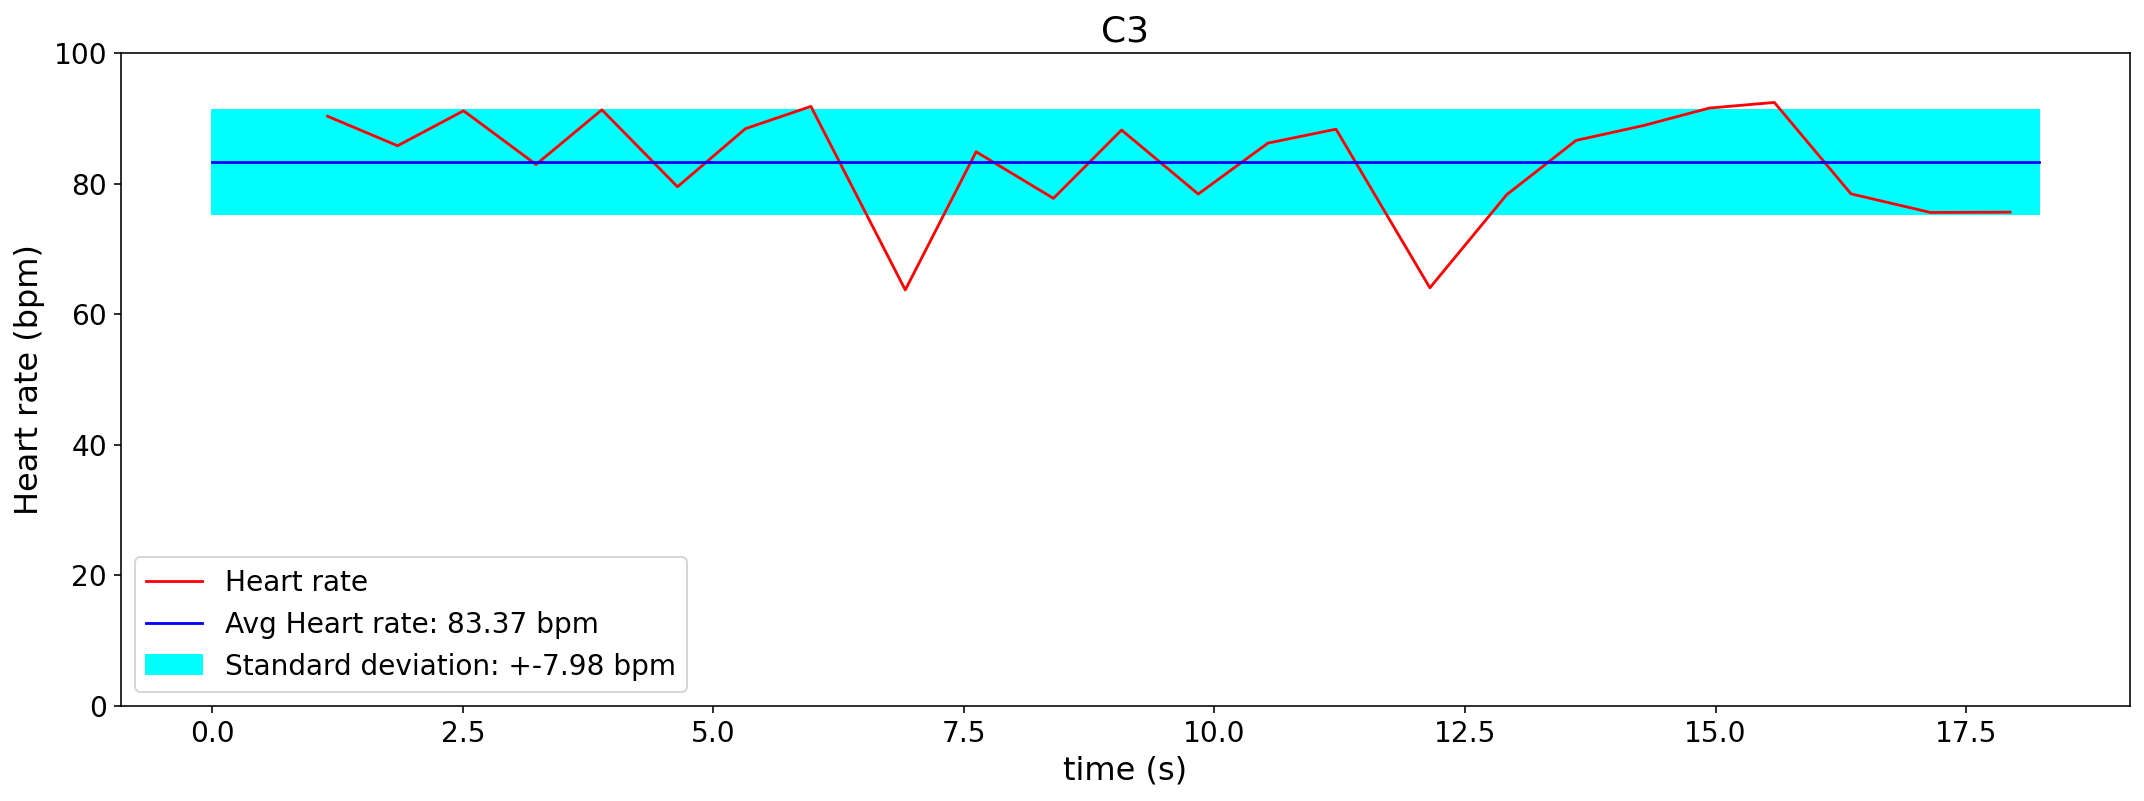

In [22]:
#We will make a graph for every subject
for i in range(0,3):
    R=pqrst[2]
    timeECG, waveData = ecg("ECG_samples/"+nice[i]+'.wav')
    
    #The heart rate is calculated from the R-R segment
    hr=[]
    for j in range(1,len(R[i])):
        heart_rate=60/(timeECG[R[i][j]]-timeECG[R[i][j-1]])
        hr.append(heart_rate)
        
    #Plot of heart rate with average and standard deviation    
    plt.figure(figsize=(18,6))
    plt.xlabel(r'time (s)')
    plt.ylabel(r'Heart rate (bpm)')
    plt.plot(timeECG[R[i][1:]],hr, 'r',label='Heart rate')
    plt.plot([timeECG[0],timeECG[-1]],[np.mean(hr),np.mean(hr)], 'b',label='Avg Heart rate: '+f'{np.mean(hr):.2f}'+' bpm')
    plt.fill_between([timeECG[0],timeECG[-1]],[np.mean(hr)+np.std(hr),np.mean(hr)+np.std(hr)],[np.mean(hr)-np.std(hr),np.mean(hr)-np.std(hr)],color='cyan', label="Standard deviation: +-"+f'{np.std(hr):.2f}'+" bpm")
    plt.title(nice[i])
    plt.ylim(0,100)
    plt.legend()
    plt.show()

### QRS complex duration:

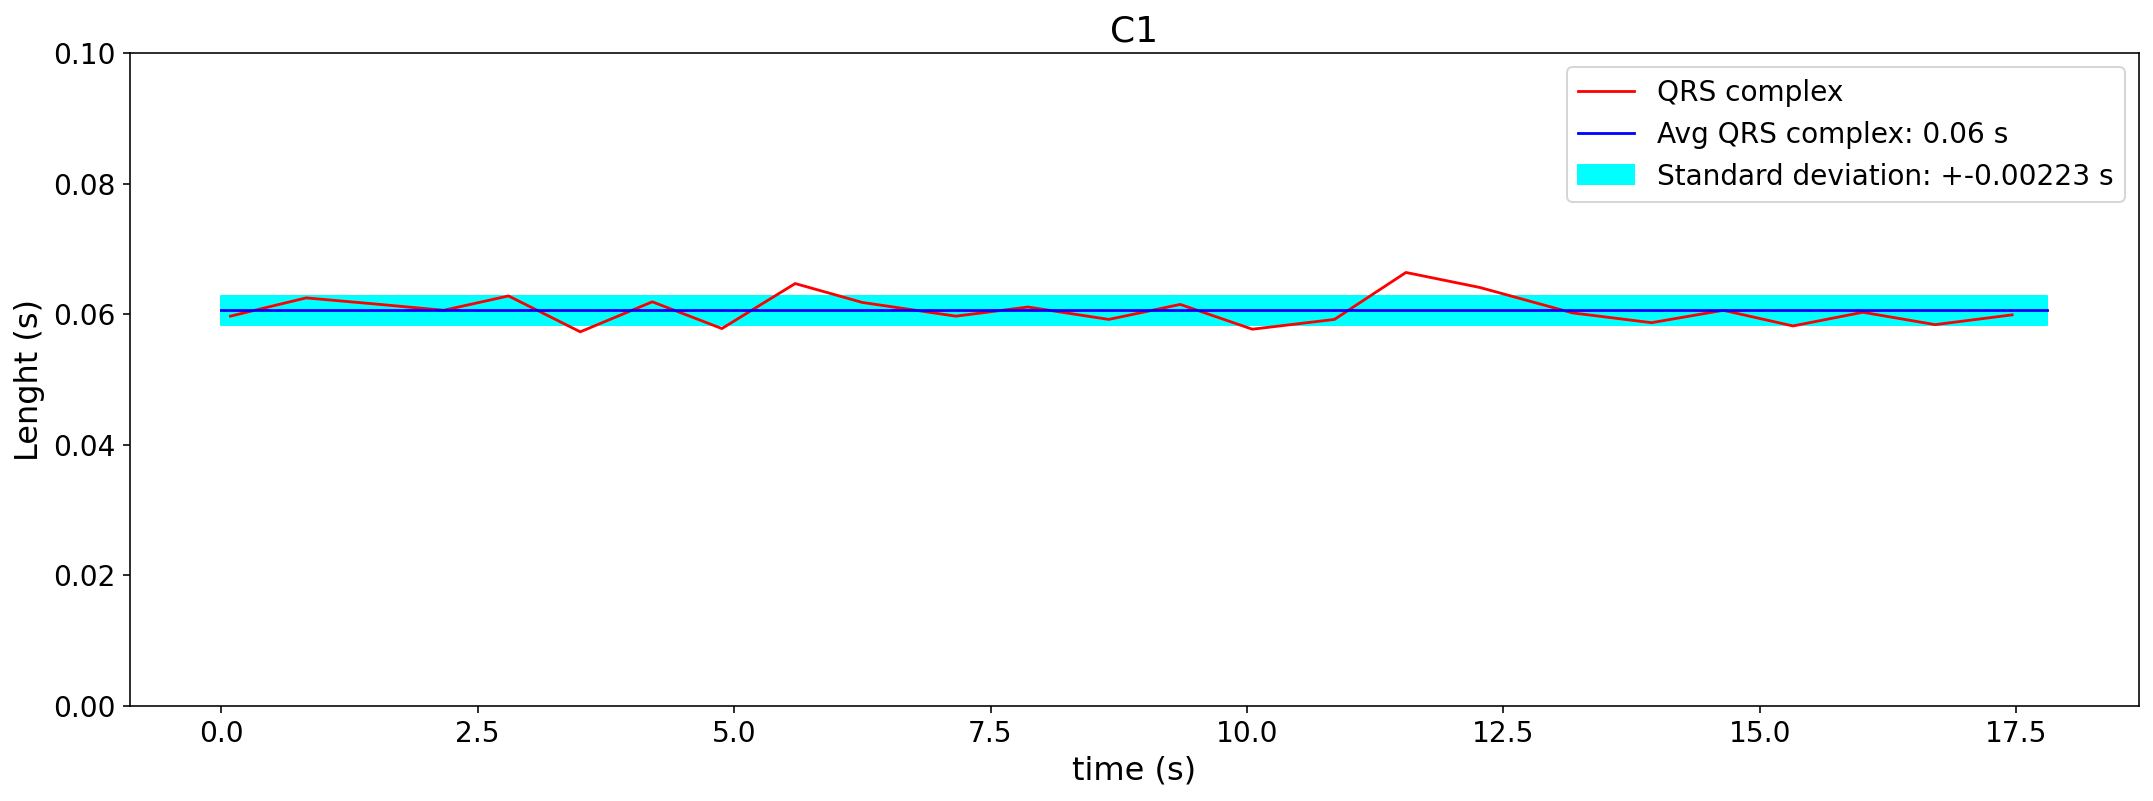

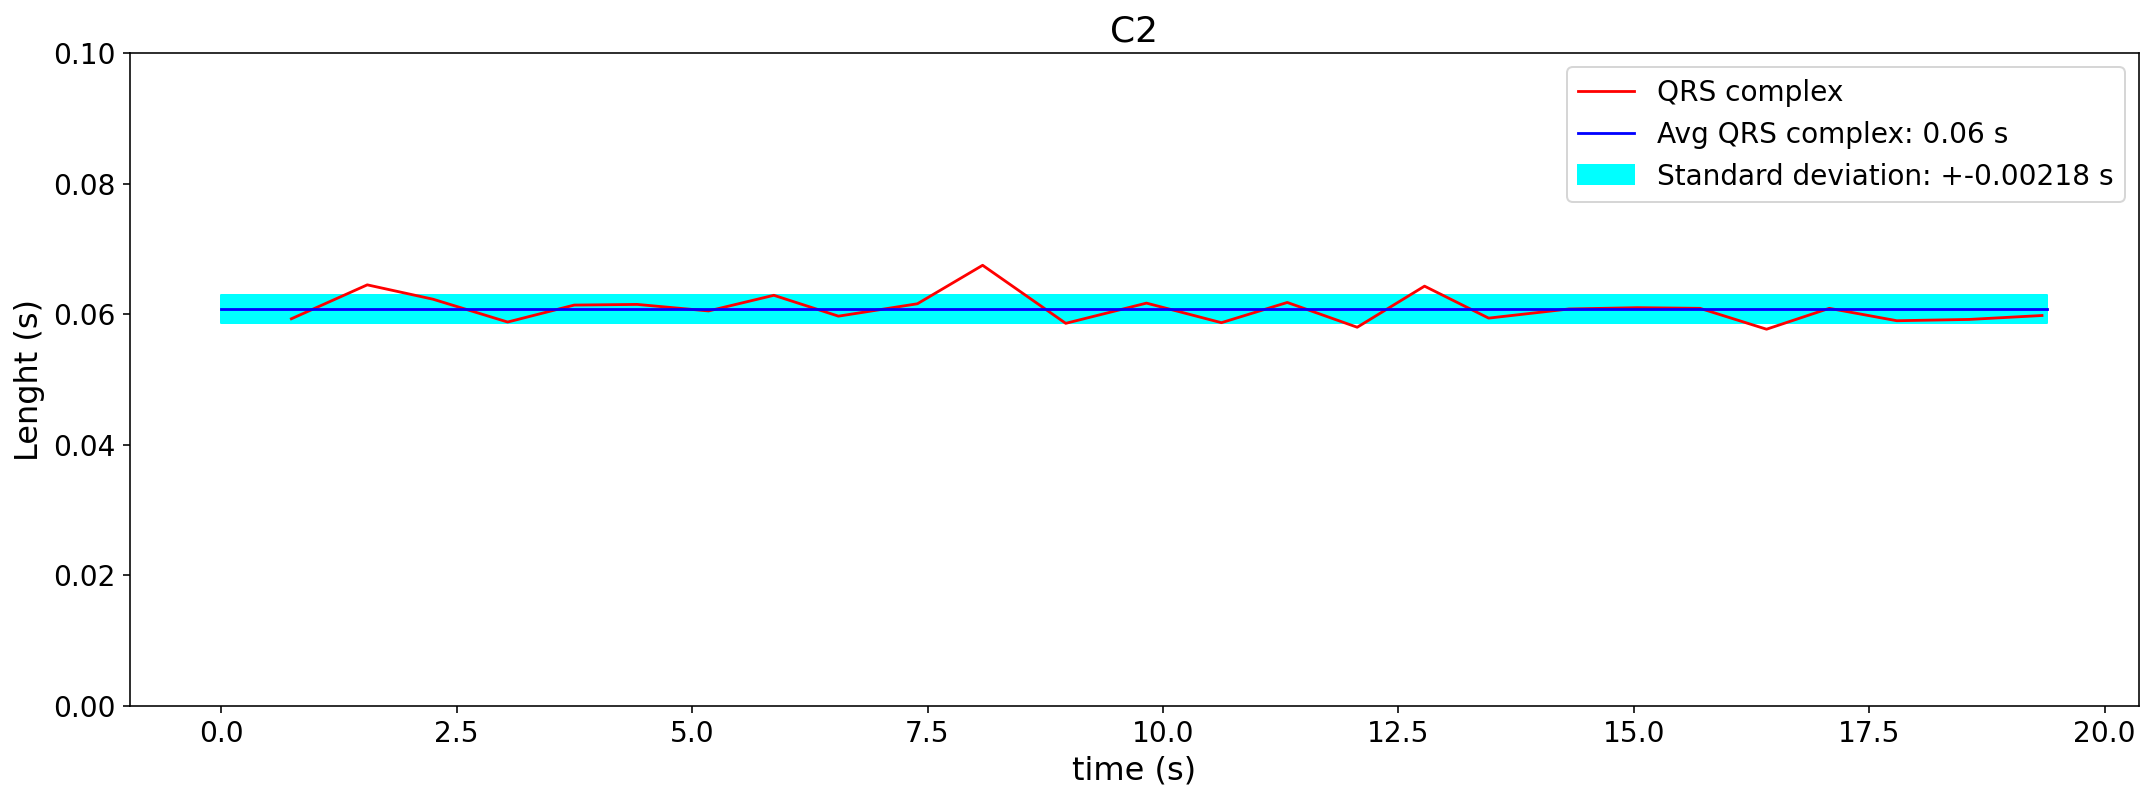

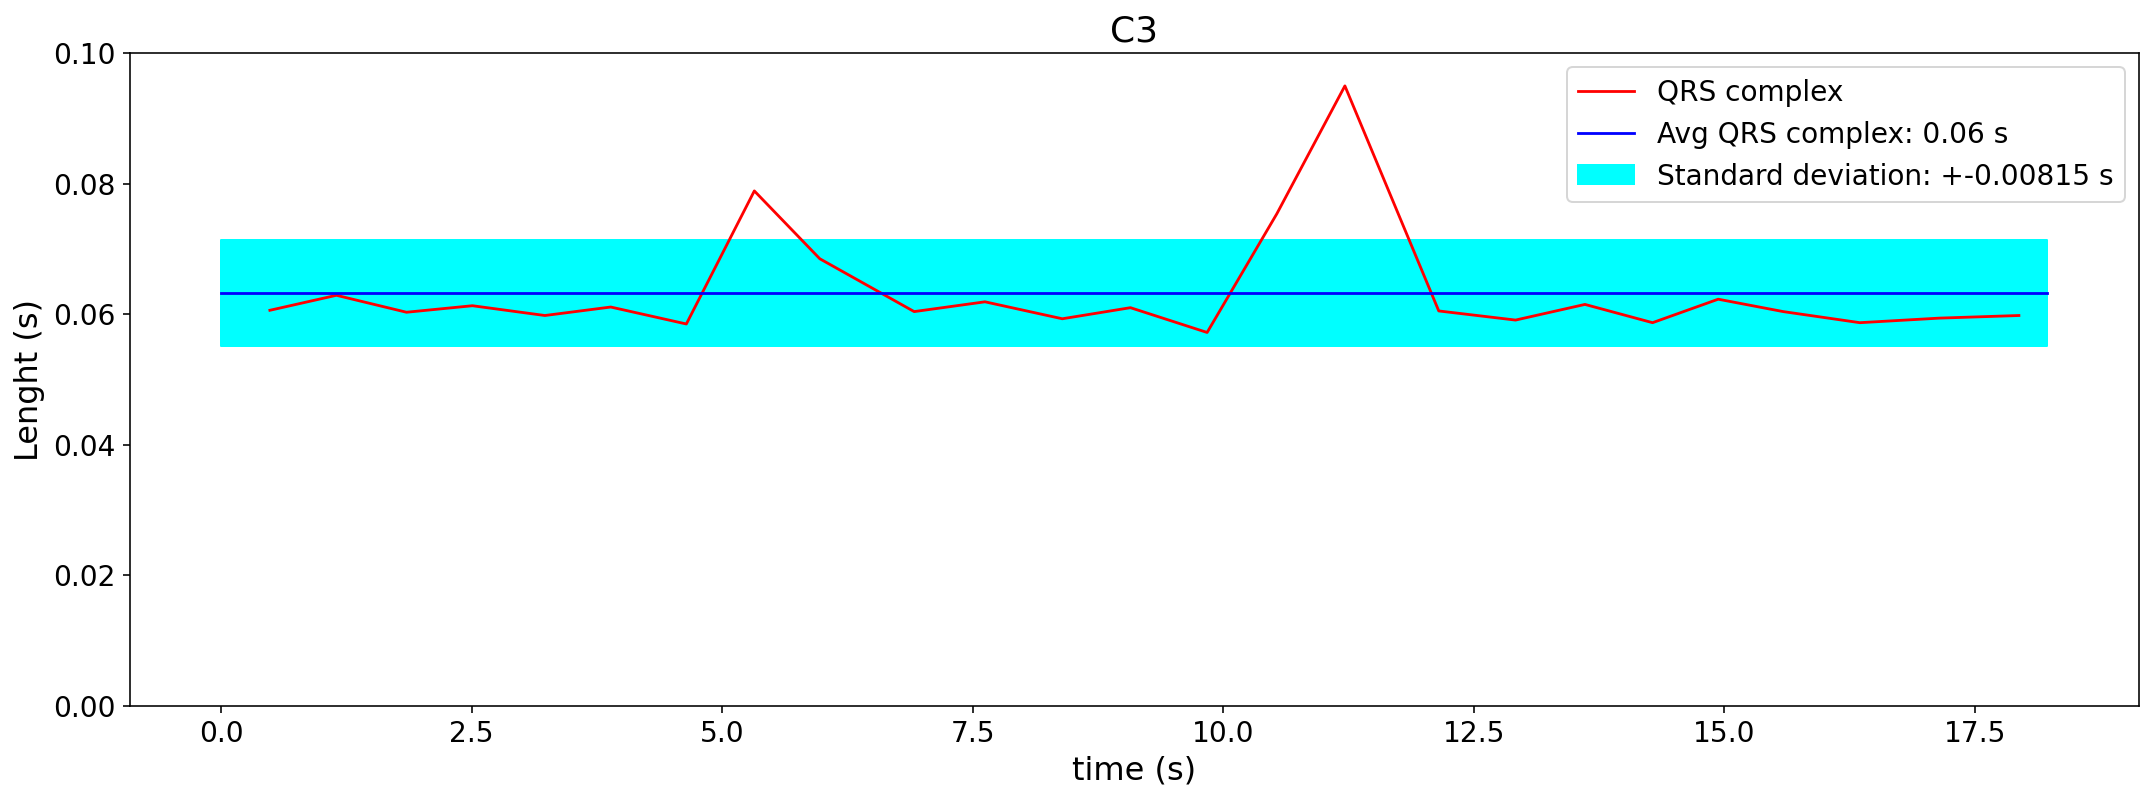

In [23]:
for i in range(0,3):
    R=pqrst[2]
    timeECG, waveData = ecg("ECG_samples/"+nice[i]+'.wav')
    
    #The QRS complex duration is calculated from the Q and S waves
    qrs_complex=[]
    for j in range(0,len(R[i])):
        qrs=timeECG[pqrst[3][i][j]]-timeECG[pqrst[1][i][j]]
        qrs_complex.append(qrs)
        
    
    #Plot of QRS Complex duration with average and standard deviation      
    plt.figure(figsize=(18,6))
    plt.xlabel(r'time (s)')
    plt.ylabel(r'Lenght (s)')
    plt.plot(timeECG[R[i]],qrs_complex, 'r',label='QRS complex')
    avg=np.mean(qrs_complex)
    std=np.std(qrs_complex)
    plt.plot([timeECG[0],timeECG[-1]],[avg,avg], 'b',label='Avg QRS complex: '+f'{np.mean(avg):.2f}'+' s')
    plt.fill_between([timeECG[0],timeECG[-1]],[avg+std,avg+std],[avg-std,avg-std],color='cyan', label="Standard deviation: +-"+f'{std:.5f}'+" s")
    plt.title(nice[i])
    plt.ylim(0,0.1)
    plt.legend()
    plt.show()

### P wave:

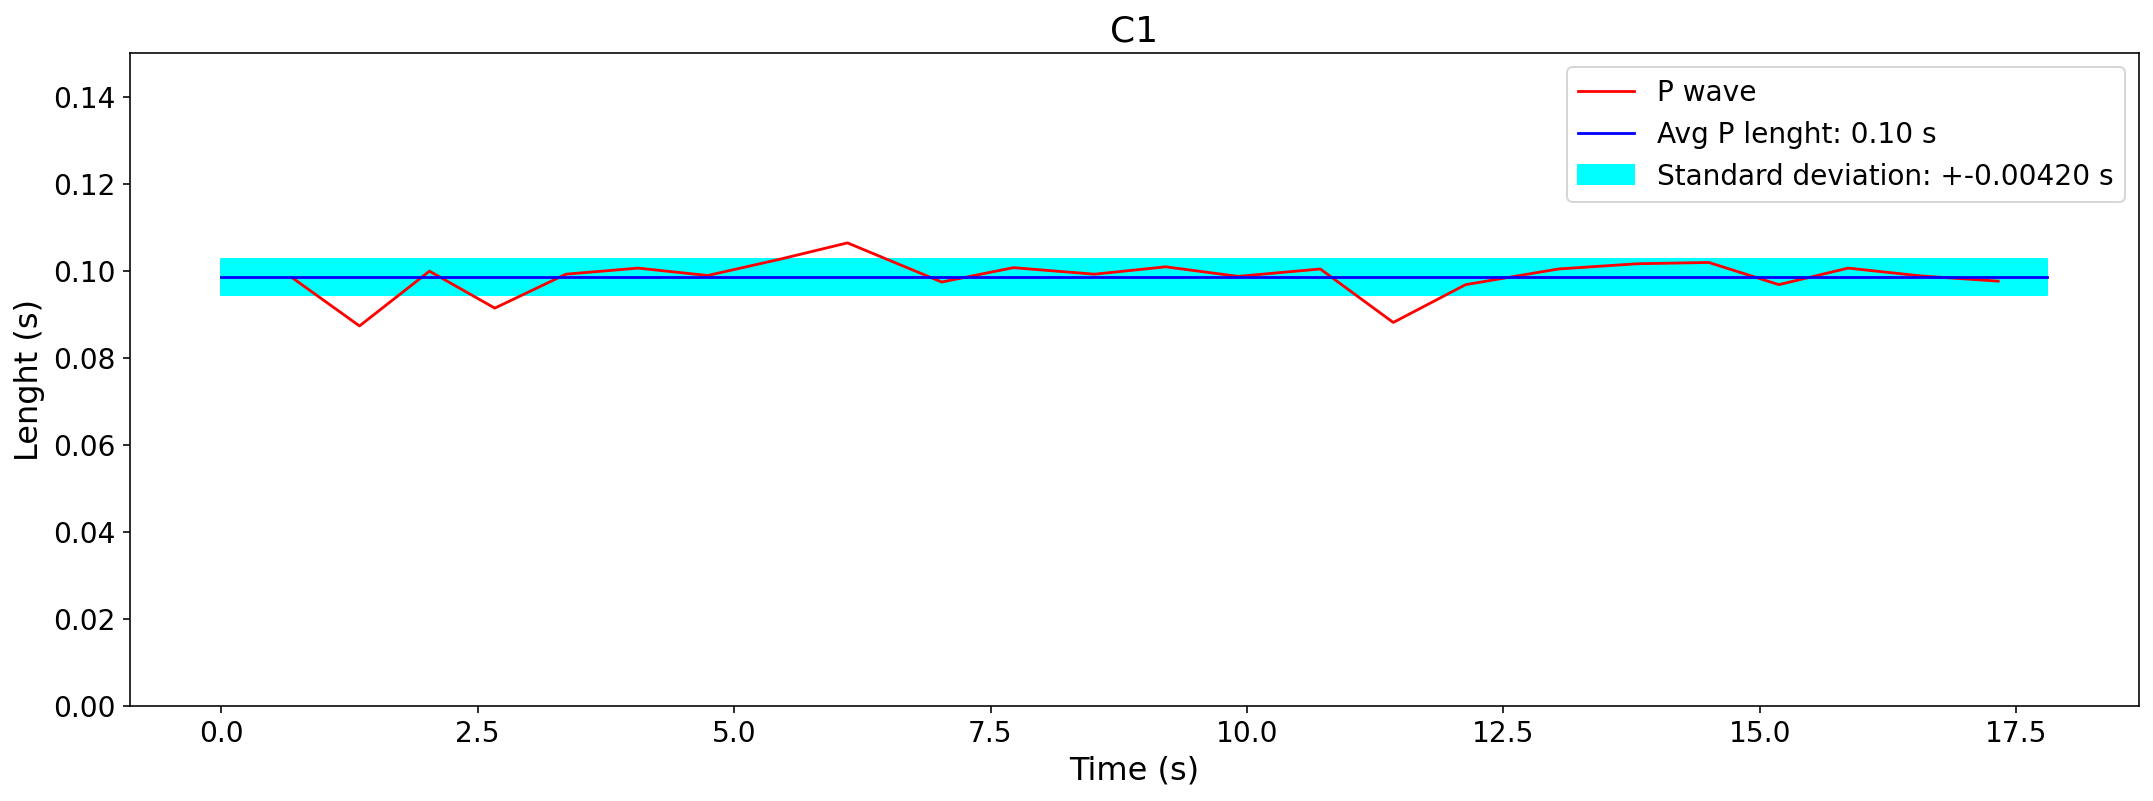

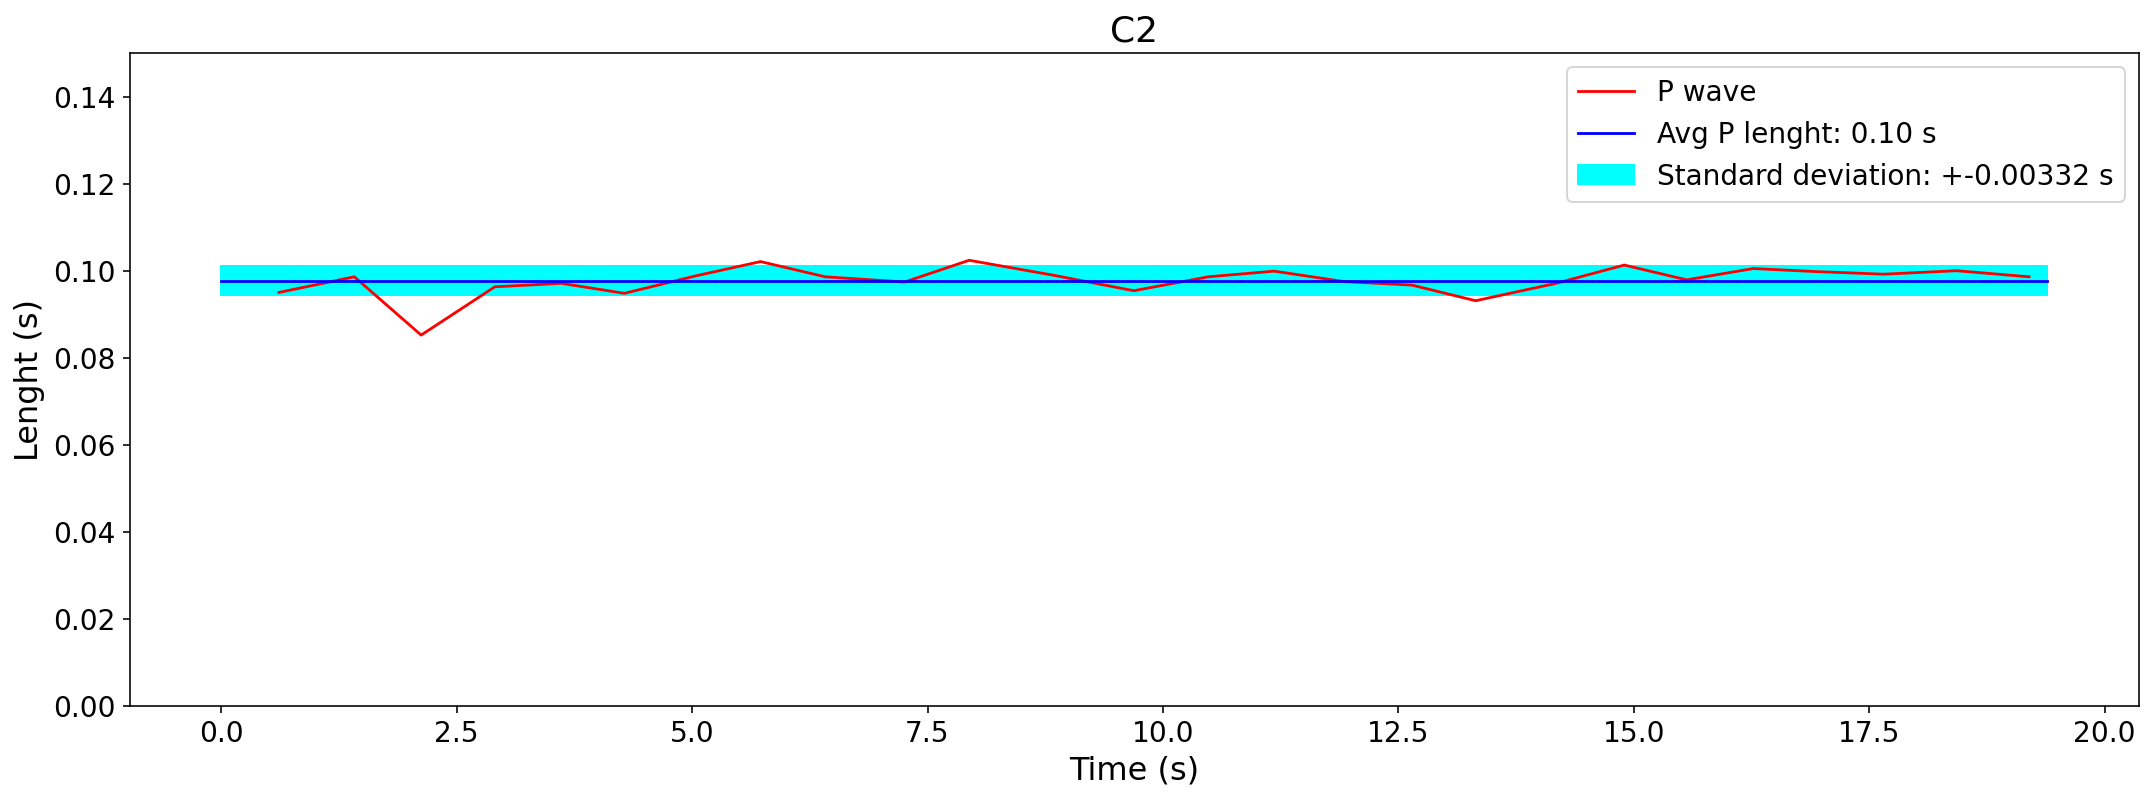

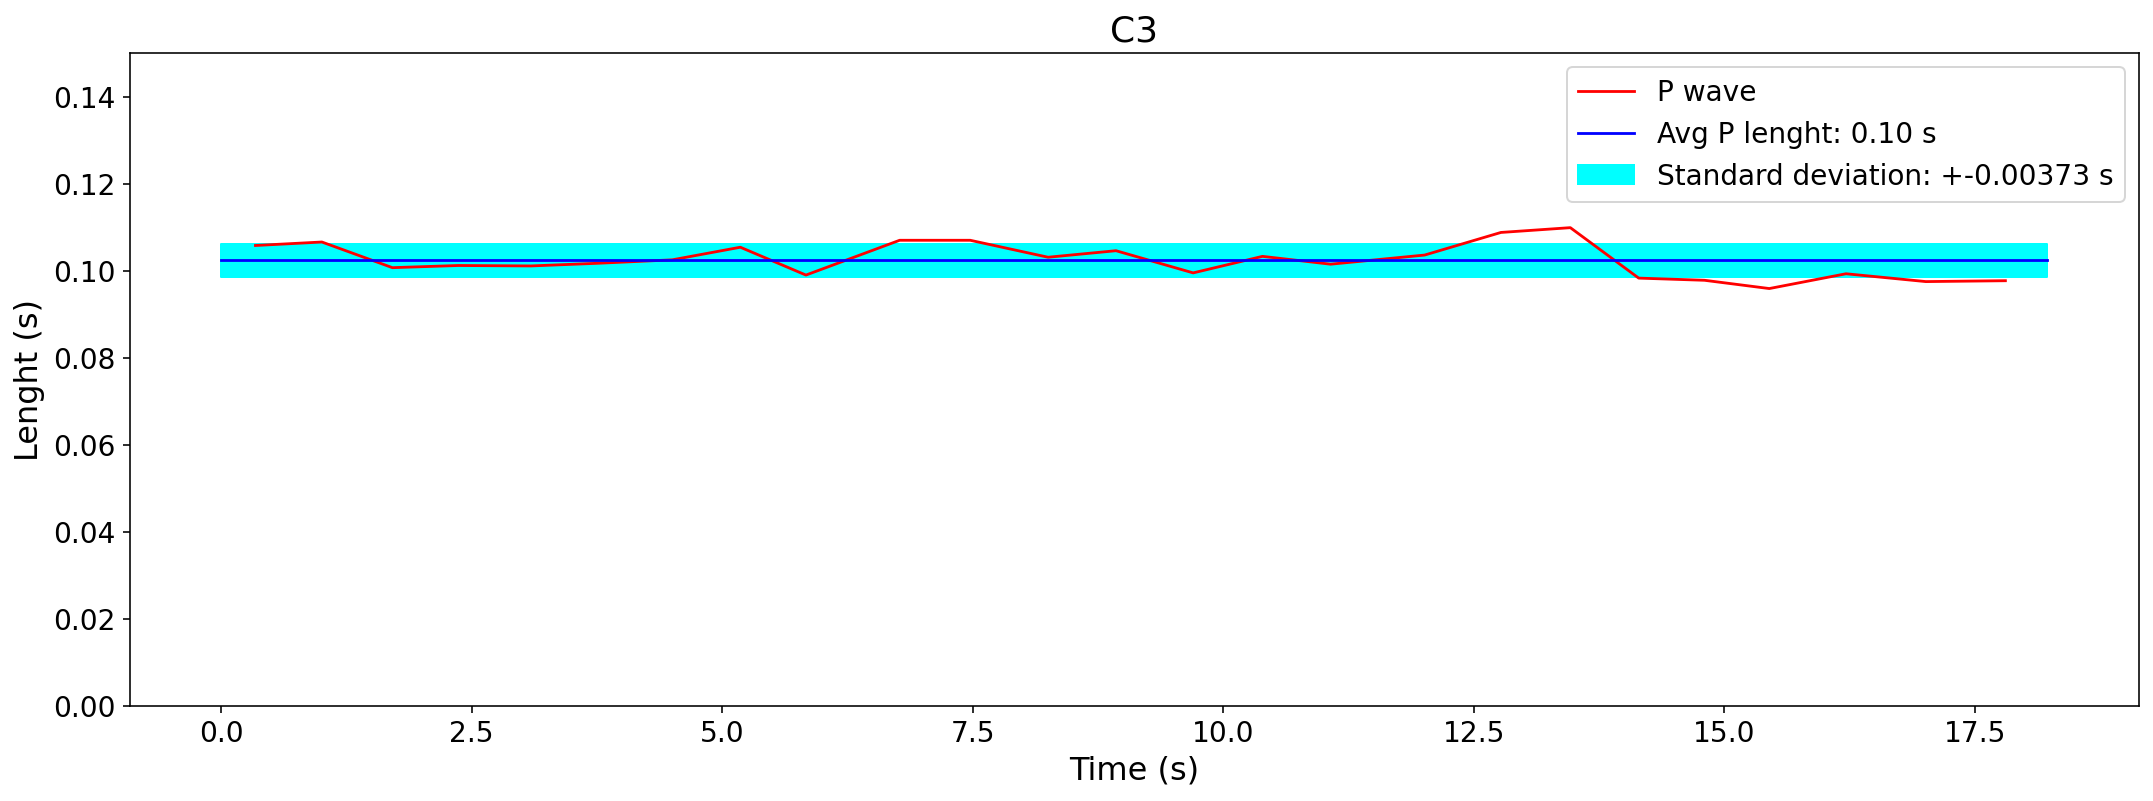

In [24]:
for i in range(0,3):
    P=pqrst[0]
    timeECG, waveData = ecg("ECG_samples/"+nice[i]+'.wav')
    p_complex=[]
    for j in range(0,len(P[i][0])):
        p=timeECG[P[i][1][j]]-timeECG[P[i][0][j]]
        p_complex.append(p)
        
    plt.figure(figsize=(18,6))
    plt.xlabel(r'Time (s)')
    plt.ylabel(r'Lenght (s)')
    plt.plot(timeECG[P[i][0]],p_complex, 'r',label='P wave')
    avg=np.mean(p_complex)
    std=np.std(p_complex)
    plt.plot([timeECG[0],timeECG[-1]],[avg,avg], 'b',label='Avg P lenght: '+f'{np.mean(avg):.2f}'+' s')
    plt.fill_between([timeECG[0],timeECG[-1]],[avg+std,avg+std],[avg-std,avg-std],color='cyan', label="Standard deviation: +-"+f'{std:.5f}'+" s")
    plt.title(nice[i])
    plt.ylim(0,0.15)
    plt.legend()
    plt.show()

### T wave

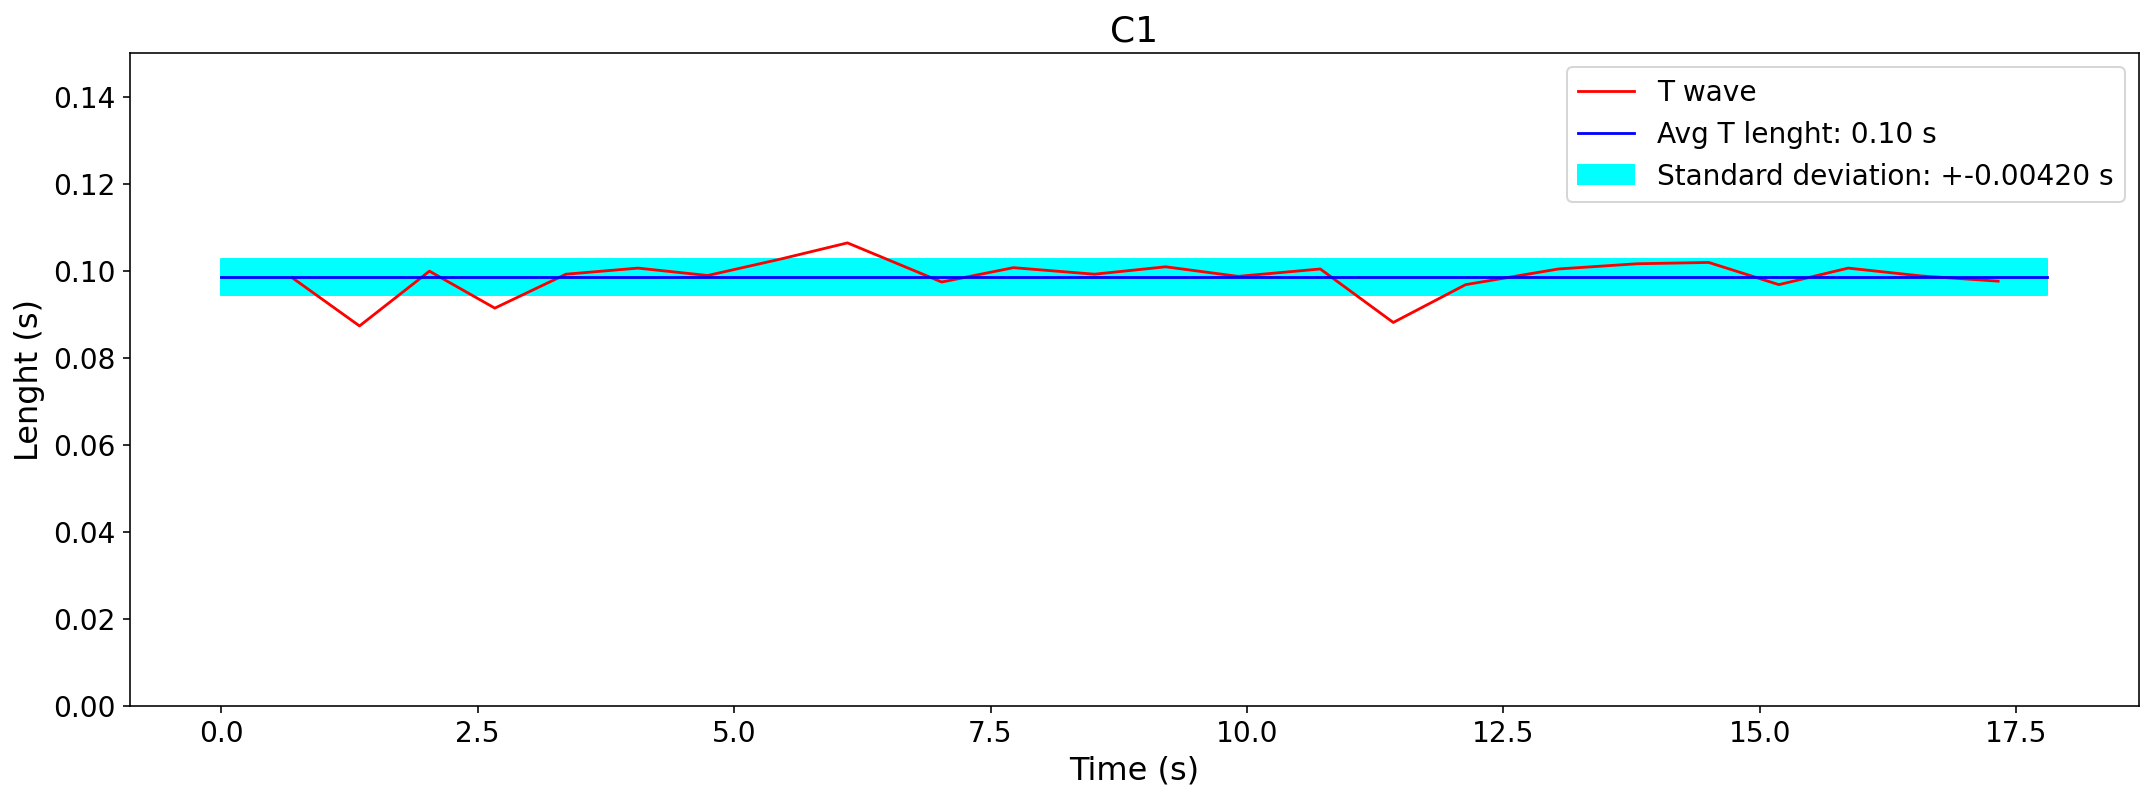

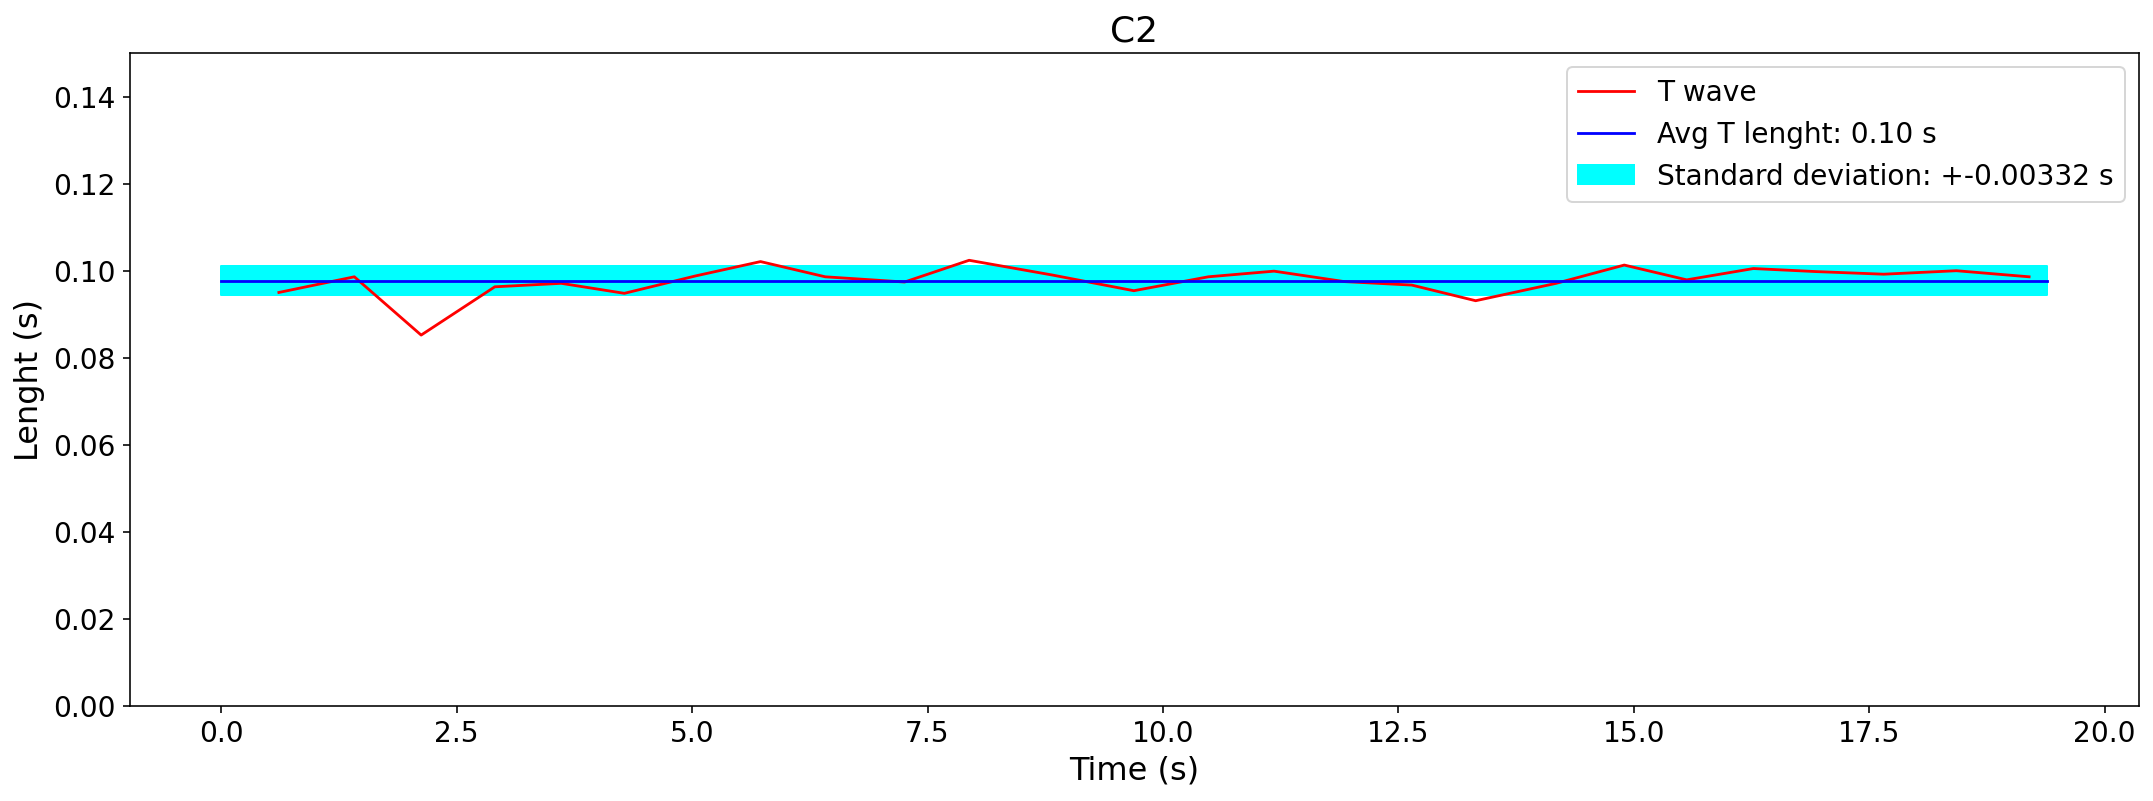

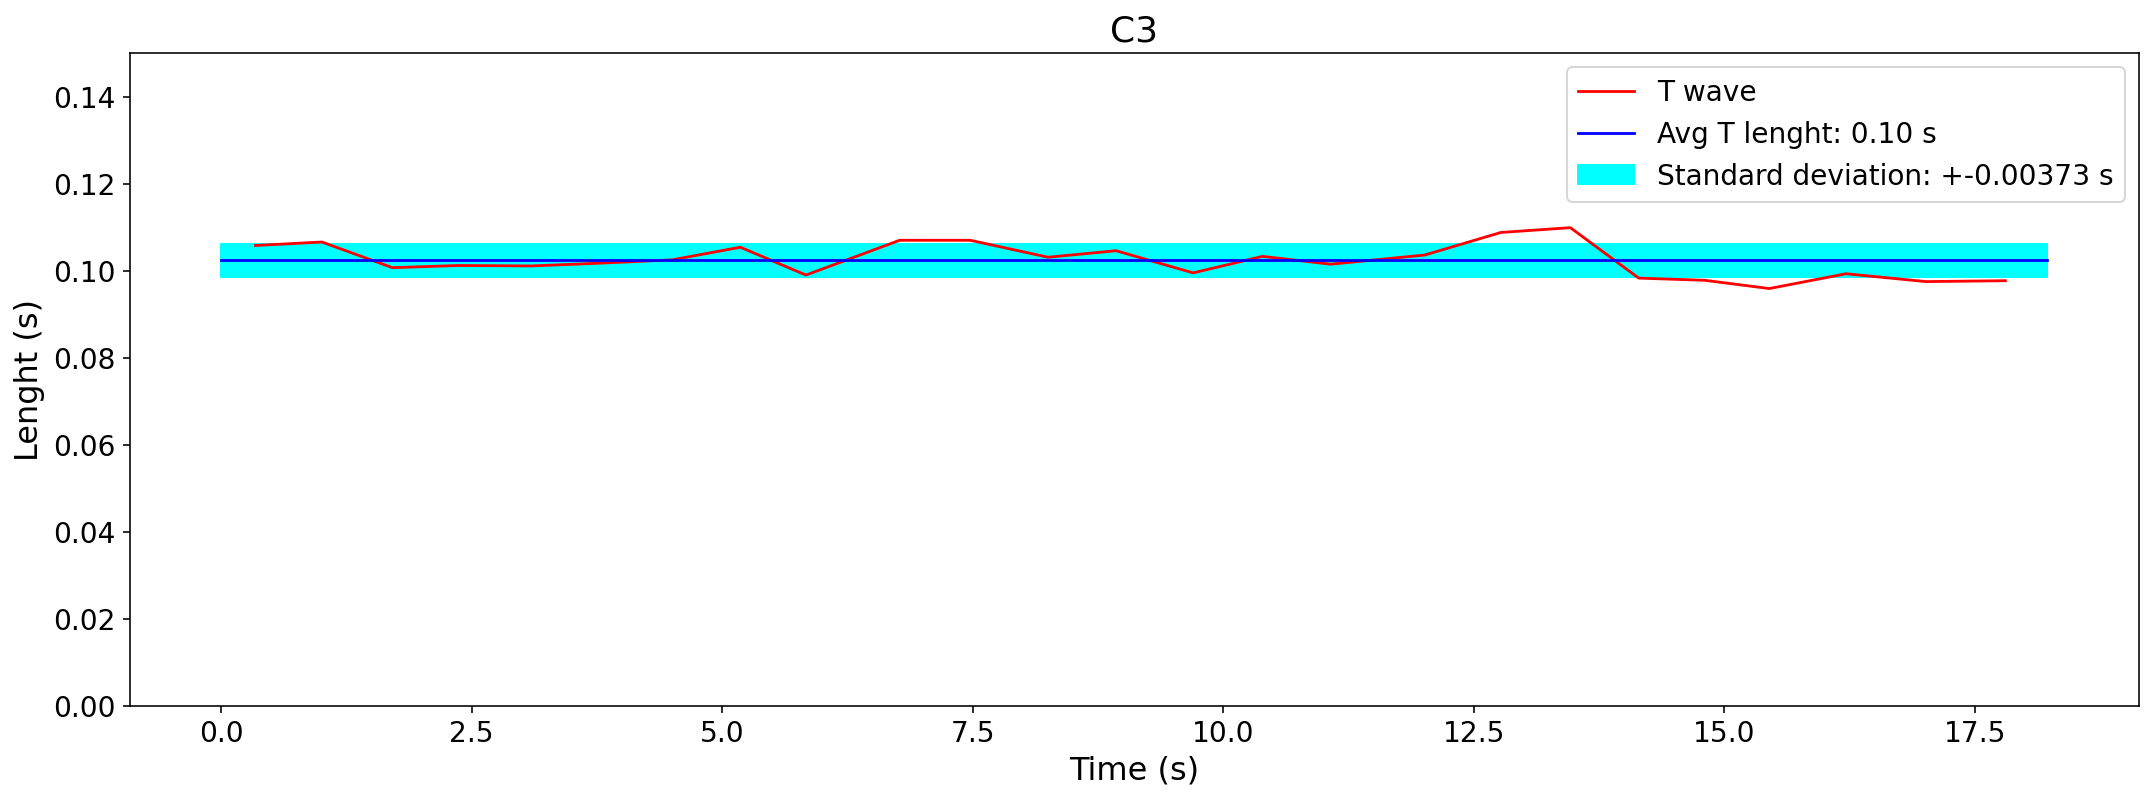

In [25]:
for i in range(0,3):
    T=pqrst[0]
    timeECG, waveData = ecg("ECG_samples/"+nice[i]+'.wav')
    t_complex=[]
    for j in range(0,len(P[i][0])):
        t=timeECG[T[i][1][j]]-timeECG[T[i][0][j]]
        t_complex.append(t)
        
    plt.figure(figsize=(18,6))
    plt.xlabel(r'Time (s)')
    plt.ylabel(r'Lenght (s)')
    plt.plot(timeECG[T[i][0]],t_complex, 'r',label='T wave')
    avg=np.mean(t_complex)
    std=np.std(t_complex)
    plt.plot([timeECG[0],timeECG[-1]],[avg,avg], 'b',label='Avg T lenght: '+f'{np.mean(avg):.2f}'+' s')
    plt.fill_between([timeECG[0],timeECG[-1]],[avg+std,avg+std],[avg-std,avg-std],color='cyan', label="Standard deviation: +-"+f'{std:.5f}'+" s")
    plt.title(nice[i])
    plt.ylim(0,0.15)
    plt.legend()
    plt.show()

## WFDB Database

Now we will use the wfdb database and apply the functions we just created.

In [26]:
#The modules are imported
from IPython.display import display
import os
import shutil
import posixpath

import wfdb

Now we redefine the functions just as before but with some modifications to match the same structure (now we don't have only 3 subjects).

In [27]:
def last_min(f,x0, w=18):
    if x0<w:
        x=np.argmin(f[:x0])
        return(x+x0)
    else:
        x=np.argmin(f[x0-w:x0])
        return(x+x0-w)
def next_min(f,x0, w=18):
    x=np.argmin(f[x0:x0+w])
    return(x+x0)
def next_same(f,x0):
    a=x0+2
    while f[a]>f[x0]:
        a+=1
    return a 

In [28]:
def QRS(timeECG,waveData,x2,threshold_ratio,fs):
    mxs_indices = detecta_maximos_locales(timeECG[2:], x2[2:],threshold_ratio)
    
    Q=[]
    R=[]
    S=[]
    qrs_lenght=[]
    for r in mxs_indices:
        r+=2
        Q.append(last_min(waveData,r,w=int(fs*0.08)))
        S.append(next_min(waveData,r,w=int(fs*0.08)))
        qrs_lenght.append((S[-1]-Q[-1])/fs)
        qrs_complex=waveData[Q[-1]:S[-1]]
        R.append(np.argmax(qrs_complex)+Q[-1])
    r=[np.mean(qrs_lenght),np.max(qrs_lenght),np.min(qrs_lenght)]
    
    # Plotting EMG signal
    plt.figure(figsize=(18,6))
    plt.xlabel(r'time (s)')
    plt.ylabel(r'voltage ($\mu$V)')
    plt.plot(timeECG,waveData, 'b')
    #plt.plot(timeECG,2*x2.real,'g')
    plt.scatter(timeECG[R], waveData[R], color='r')
    plt.scatter(timeECG[Q], waveData[Q], color='g')
    plt.scatter(timeECG[S], waveData[S], color='m')
    #plt.xlim(20,28)
    #plt.title(file.split("/")[1])
    plt.show();
    return Q,R,S,r

In [29]:
def R_fourier(file,fm,fM,threshold_ratio=0.7):
    record = wfdb.rdrecord(file, sampto = 15000)
    waveData = record.p_signal[:,0]
    timeECG = np.array([i/record.fs for i in range(0, len(waveData))])
    
    #The Fourier transform is generated through the fft function
    X=np.fft.fft(waveData)
    N = len(X)
    n = np.arange(N)
    T = N*(timeECG[1]-timeECG[0])
    freq = n/T
    
    #The Foruier transform is filtered 
    xc=X.copy()
    xc[freq<fm]=0
    xc[freq>fM]=0
    x2=np.fft.ifft(xc)
    
    #Spliting in segments of 20s
    #tt: Total time
    tt=timeECG[-1]
    #spm: Samples per measurment
    spm=int(tt//20)
    r=[]
    for i in range(0,spm):
        spm_i=i*record.fs*20
        spm_f=spm_i+record.fs*20
        Q,R,S,a=QRS(timeECG[spm_i:spm_f],waveData[spm_i:spm_f],x2[spm_i:spm_f],threshold_ratio,record.fs)
        hr=[]
        
        for j in range(1,len(R)):
            heart_rate=60/(timeECG[R[j]]-timeECG[R[j-1]])
            hr.append(heart_rate)
        r.append([a[0],a[1],a[2],np.mean(hr)])
    
    return(r)

In [30]:
#Testing the funtions
r=R_fourier('mit-bih-arrhythmia-database-1.0.0/101',5,35,threshold_ratio=0.7)

FileNotFoundError: [Errno 2] No such file or directory: '/Users/javierserranomolina/Documents/GitHub/Servicio_social/ECG/Code/mit-bih-arrhythmia-database-1.0.0/101.hea'

In [ ]:
record = wfdb.rdrecord('mit-bih-arrhythmia-database-1.0.0/101', sampto = 15000)
waveData = record.p_signal[:,0]
timeECG = np.array([i/record.fs for i in range(0, len(waveData))])

In [ ]:
plt.figure(figsize=(18,6))
plt.xlabel(r'time (s)')
plt.ylabel(r'voltage ($\mu$V)')
plt.plot(timeECG,waveData)
plt.show;

## Applying the funtions to all the recordings


In [ ]:
file=open("mit-bih-arrhythmia-database-1.0.0/RECORDS","r")
a=file.read()
b=a.split(a[3])
b.pop()
b=np.array(b)
ra=[[0.1,0.01,60,6]]

#The following line only includes the recordings that are valid.
#Only one of the next two lines should be left uncommented.
#for record in b[[0,1,3,5,6,12,14,15,16,19,24,26,28,30,32,33,37,38,41,44,47]]:
for record in b:
    file="mit-bih-arrhythmia-database-1.0.0/"+record
    ra=np.append(ra,R_fourier(file,5,35,threshold_ratio=0.5),axis=0)

Notice that some recording have too much noise or aren't clear. This is translated to errors in the analysis. Find out which ones are valid and which ones are not. 

Now we do the same with the data that corresponds to normal subjects.

In [ ]:
file=open("mit-bih-normal-sinus-rhythm-database-1.0.0/RECORDS","r")
a=file.read()
b=a.split(a[5])
b.pop()
b=np.array(b)
rn=[[0.1,0.01,60,6]]

#The following line only includes the recordings that are valid.
#Only one of the next two lines should be left uncommented.
#for record in b[[0,2,4,5,6,10,11,12]]:
for record in b:
    file="mit-bih-normal-sinus-rhythm-database-1.0.0/"+record
    rn=np.append(rn,R_fourier(file,5,35,threshold_ratio=0.7),axis=0)
rn=np.delete(rn,0,axis=0)

Remember that each entry of the output *rn* and *ra* has the following structure: 

0: Mean QRS lenght
***
1: Max QRS lenght
***
2: Min QRS lenght
***
3: Mean Heart Rate